In [ ]:
 # mount google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Loading data...
Loaded 100 samples
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 445s 22s/step - accuracy: 0.8012 - loss: 0.6411
Epoch 2/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 442s 22s/step - accuracy: 0.9507 - loss: 0.1331
Epoch 1/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 999ms/step - accuracy: 0.1499 - loss: 0.3986
Epoch 2/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.0470 - loss: 0.1996
Evaluating U-Net...
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step
Mean IoU: 0.6468, Dice: 0.7690

Evaluating Classifier...
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Classification Report:
                              precision    recall  f1-score   support

 Abnormal_vein_Elsewhere_NVE       0.00      0.00      0.00         0
          Abnormal_vein_IRMA       1.00      1.00      1.00        20
Abnormal_vein_Optic_Disk_NVD       0.00      0.00      0.00         0
           Cotton_Wool_Spots       1.00      1.00      1.00        20
                    Exudates       1.00      1.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


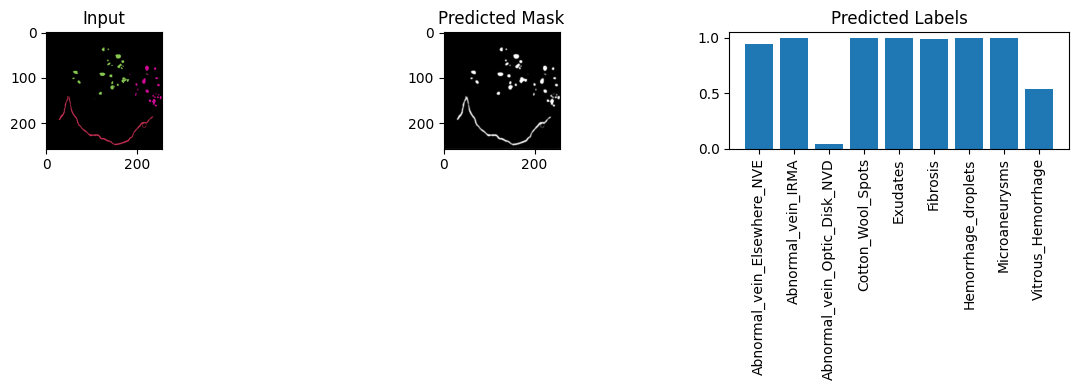

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.measure import label
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score

# Configuration
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
CLASS_NAMES = sorted(os.listdir(MASK_DIR))  # ['Exudates', 'Hemorrhage', ...]
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(CLASS_NAMES)

# Utility: Load and preprocess a single image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found or unreadable: {image_path}")

    img = cv2.resize(img, IMAGE_SIZE)  # e.g., (224, 224)

    if len(img.shape) == 2:  # grayscale image
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # convert to 3-channel BGR

    img = img / 255.0
    return img

# Utility: Load and combine masks
def load_mask_and_count(image_id):
    base_id = os.path.splitext(image_id)[0]  # e.g., 'img_101'
    mask = np.zeros((*IMAGE_SIZE, NUM_CLASSES), dtype=np.uint8)
    counts = []

    for i, cls in enumerate(CLASS_NAMES):
        found = False
        # Try possible mask filenames
        possible_filenames = [
            f"{base_id}_{cls}.png",
            f"{base_id}.png",
            f"{base_id}_{cls}.jpg",
            f"{base_id}.jpg",
            f"{base_id}.tif",
            f"{base_id}.tiff",
            f"{base_id}.bmp"
        ]

        for fname in possible_filenames:
            mask_path = os.path.join(MASK_DIR, cls, fname)
            if os.path.exists(mask_path):
                m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    m = cv2.resize(m, IMAGE_SIZE)
                    m = (m > 10).astype(np.uint8)
                    mask[..., i] = m
                    counts.append(label(m).max())
                    found = True
                    break
        if not found:
            counts.append(0)  # No mask found for this class

    return mask, counts

# Build dataset
images = []
labels = []
counts = []

image_ids = os.listdir(IMAGE_DIR)
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

for image_id in image_ids:
    if not image_id.lower().endswith(valid_extensions):
        continue

    img_path = os.path.join(IMAGE_DIR, image_id)

    try:
        img = load_image(img_path)
        mask, count_vector = load_mask_and_count(image_id)
    except Exception as e:
        print(f"Skipping {image_id}: {e}")
        continue

    if (np.sum(mask) == 0):
       # print(f"No lesion found in any mask for: {image_id}, skipping...")
        continue

    label_vector = (mask.sum(axis=(0, 1)) > 0).astype(np.float32)

    if len(count_vector) != NUM_CLASSES:
        print(f"Inconsistent count length for {image_id}, skipping...")
        continue

    images.append(img)
    labels.append(label_vector)
    counts.append(count_vector)

# Convert to arrays
X_img = np.array(images, dtype=np.float32)
X_counts = np.array(counts, dtype=np.float32)
Y = np.array(labels, dtype=np.float32)

print(f"Total usable images: {len(X_img)}")

# Split
X_img_train, X_img_val, X_counts_train, X_counts_val, Y_train, Y_val = train_test_split(
    X_img, X_counts, Y, test_size=0.2, random_state=42
)

# --- Model ---
# Model
def build_model(input_shape=(224, 224, 3), count_shape=(NUM_CLASSES,)):
    image_input = Input(shape=input_shape)
    count_input = Input(shape=count_shape)

    base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=image_input)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    combined = Concatenate()([x, count_input])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.3)(combined)

    output = Dense(NUM_CLASSES, activation='sigmoid')(combined)
    return Model(inputs=[image_input, count_input], outputs=output)

model = build_model()

# Compile
model.compile(
    optimizer=Adam(1e-4),
    loss=BinaryCrossentropy(label_smoothing=0.05),
    metrics=[AUC(multi_label=True, name='auc')]
)

# Train
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(
    [X_img_train, X_counts_train], Y_train,
    validation_data=([X_img_val, X_counts_val], Y_val),
    epochs=25,
    batch_size=16,
    callbacks=[early_stop]
)

# Predict
predictions = model.predict([X_img_val, X_counts_val])
predicted_classes = (predictions > 0.1).astype(int)

# Per-class AUC
print("\n🔍 Per-Class AUC:")
for i, class_name in enumerate(CLASS_NAMES):
    try:
        auc_score = roc_auc_score(Y_val[:, i], predictions[:, i])
        print(f"{class_name:25}: AUC = {auc_score:.4f}")
    except ValueError:
        print(f"{class_name:25}: Not enough positive samples to compute AUC")

# Sample output
print("\nSample predictions:")
print(predicted_classes[:5])
print("True labels:")
print(Y_val[:5])


KeyboardInterrupt: 

In [ ]:

model_save_path = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/retina_multilabel_model.h5'
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")


Model saved at: /content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/retina_multilabel_model.h5


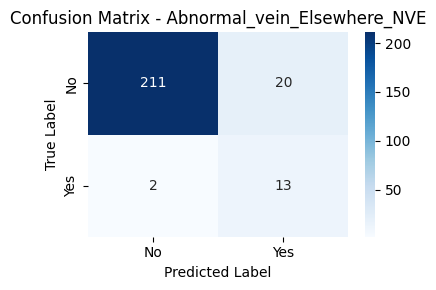

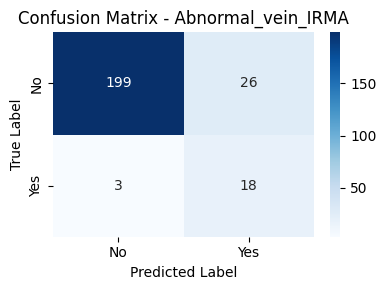

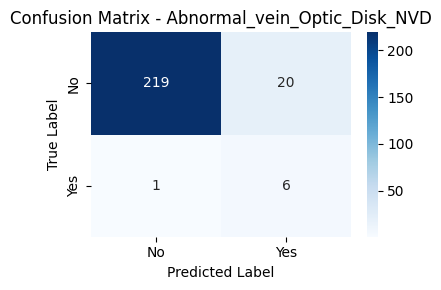

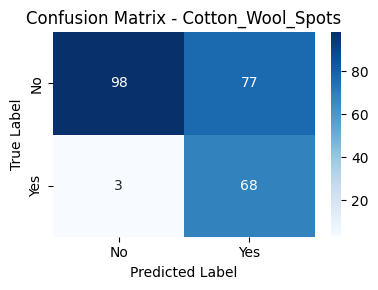

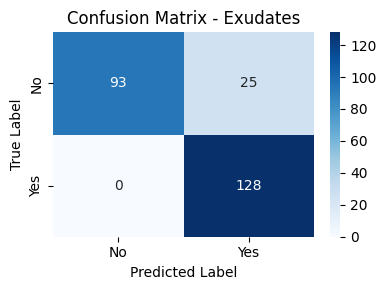

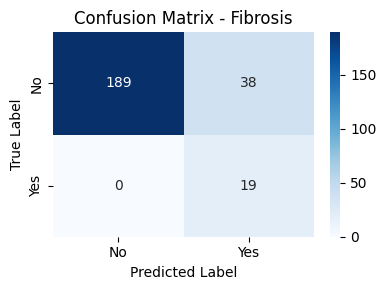

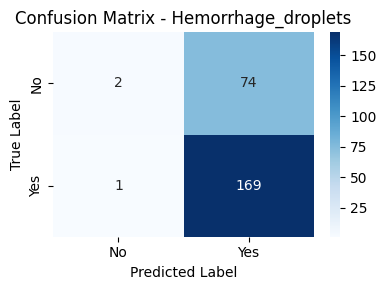

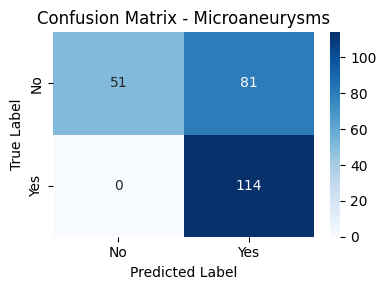

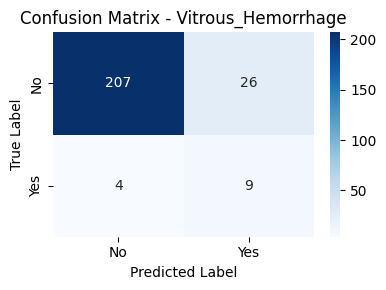

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrices = multilabel_confusion_matrix(Y_val, predicted_classes)

for i, class_name in enumerate(CLASS_NAMES):
    cm = conf_matrices[i]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix - {class_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


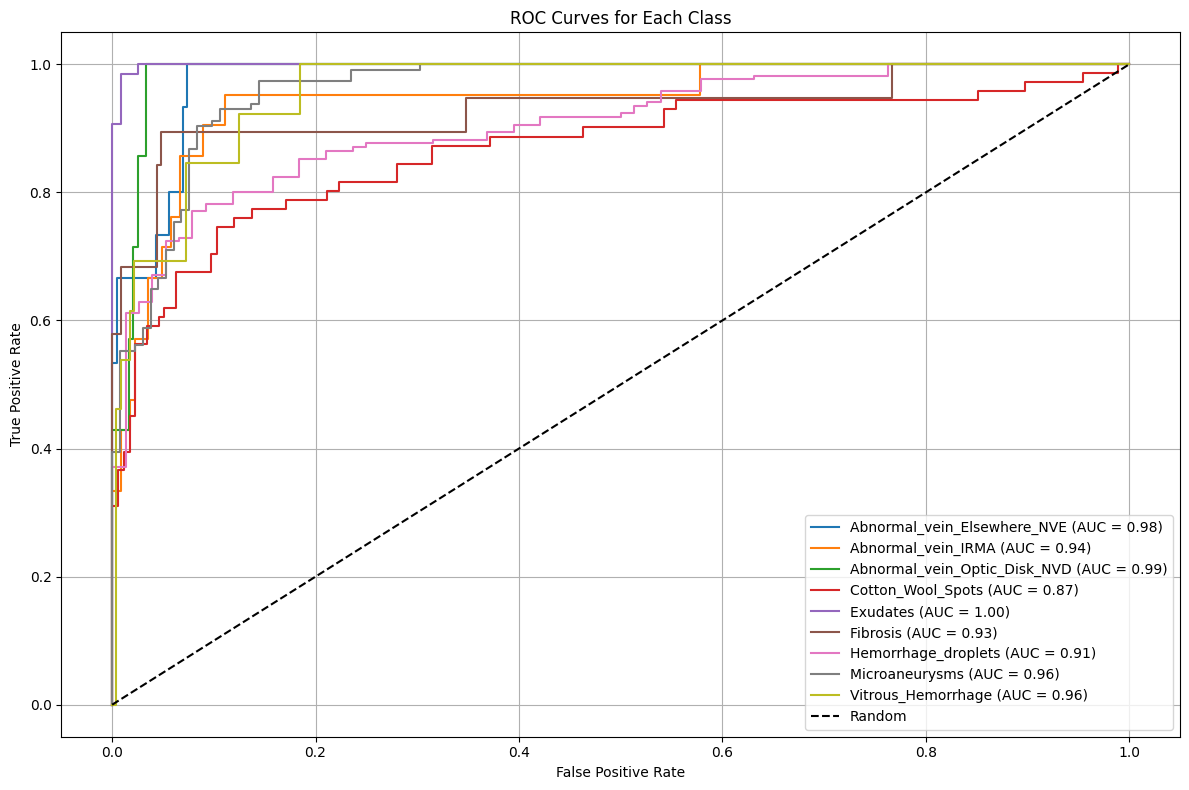

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 8))
for i, class_name in enumerate(CLASS_NAMES):
    try:
        fpr, tpr, _ = roc_curve(Y_val[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")
    except ValueError:
        print(f"⚠️ Not enough samples for class '{class_name}' to compute ROC.")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 34.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:

import os

# Set your image directory
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks/Exudates'

for filename in os.listdir(IMAGE_DIR):
    if 'SE' in filename:
        new_name = filename.replace('SE', 'EX')
        old_path = os.path.join(IMAGE_DIR, filename)
        new_path = os.path.join(IMAGE_DIR, new_name)
        os.rename(old_path, new_path)
        print(f"Renamed: {filename} -> {new_name}")



Renamed: IDRiD_59_SE.tif -> IDRiD_59_EX.tif
Renamed: IDRiD_56_SE.tif -> IDRiD_56_EX.tif
Renamed: IDRiD_55_SE.tif -> IDRiD_55_EX.tif
Renamed: IDRiD_72_SE.tif -> IDRiD_72_EX.tif
Renamed: IDRiD_71_SE.tif -> IDRiD_71_EX.tif
Renamed: IDRiD_70_SE.tif -> IDRiD_70_EX.tif
Renamed: IDRiD_68_SE.tif -> IDRiD_68_EX.tif
Renamed: IDRiD_67_SE.tif -> IDRiD_67_EX.tif
Renamed: IDRiD_61_SE.tif -> IDRiD_61_EX.tif
Renamed: IDRiD_64_SE.tif -> IDRiD_64_EX.tif
Renamed: IDRiD_60_SE.tif -> IDRiD_60_EX.tif
Renamed: IDRiD_75_SE.tif -> IDRiD_75_EX.tif
Renamed: IDRiD_74_SE.tif -> IDRiD_74_EX.tif
Renamed: IDRiD_73_SE.tif -> IDRiD_73_EX.tif


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.measure import label
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Configuration
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
CLASS_NAMES = sorted(os.listdir(MASK_DIR))
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(CLASS_NAMES)

# Load image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img = cv2.resize(img, IMAGE_SIZE)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img / 255.0

# Load masks and count connected lesions
def load_mask_and_count(image_id):
    base_id = os.path.splitext(image_id)[0]
    counts = []

    for cls in CLASS_NAMES:
        found = False
        possible_filenames = [
            f"{base_id}_{cls}.png",
            f"{base_id}.png",
            f"{base_id}_{cls}.jpg",
            f"{base_id}.jpg"
        ]
        for fname in possible_filenames:
            mask_path = os.path.join(MASK_DIR, cls, fname)
            if os.path.exists(mask_path):
                m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    m = cv2.resize(m, IMAGE_SIZE)
                    m = (m > 10).astype(np.uint8)
                    count = label(m).max()
                    counts.append(count)
                    found = True
                    break
        if not found:
            counts.append(0)
    return counts

# Load dataset
images = []
counts = []

for image_id in os.listdir(IMAGE_DIR):
    if not image_id.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        continue
    try:
        img = load_image(os.path.join(IMAGE_DIR, image_id))
        count_vector = load_mask_and_count(image_id)
        if sum(count_vector) == 0:
            continue  # Skip if no lesion found
        images.append(img)
        counts.append(count_vector)
    except Exception as e:
        print(f"Skipping {image_id}: {e}")
        continue

X = np.array(images, dtype=np.float32)
Y = np.array(counts, dtype=np.float32)

# Split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build model
def build_counting_model(input_shape=(224, 224, 3), num_outputs=NUM_CLASSES):
    image_input = Input(shape=input_shape)
    base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=image_input)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_outputs)(x)
    output = ReLU()(output)  # Ensure non-negative counts
    return Model(inputs=image_input, outputs=output)

model = build_counting_model()

# Compile
model.compile(optimizer=Adam(1e-4), loss=MeanSquaredError(), metrics=['mae'])

# Train
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop]
)

# Predict
Y_pred = model.predict(X_val)
Y_pred_rounded = np.round(Y_pred)

# Evaluate
print("\n📊 Per-Class RMSE (Root Mean Squared Error):")
for i, class_name in enumerate(CLASS_NAMES):
    rmse = np.sqrt(mean_squared_error(Y_val[:, i], Y_pred[:, i]))
    print(f"{class_name:25}: RMSE = {rmse:.2f}")

# Sample prediction
print("\n🖼 Sample Prediction vs Ground Truth:")
for i in range(3):
    print(f"\nImage {i+1}")
    print("Predicted :", dict(zip(CLASS_NAMES, Y_pred_rounded[i].astype(int))))
    print("Actual    :", dict(zip(CLASS_NAMES, Y_val[i].astype(int))))


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-adb8d0a5419d>", line 68, in <cell line: 0>
    count_vector = load_mask_and_count(image_id)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-23-adb8d0a5419d>", line None, in load_mask_and_count
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.p

In [ ]:
model_save_path = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/retina_multilabel_model_Countdown.h5'
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/retina_multilabel_model_Countdown.h5


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ReLU

# Load custom model with ReLU in output
model = load_model('/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/retina_multilabel_model.h5', custom_objects={'ReLU': ReLU})

def predict_and_show(image_path):
    # Load image
    img = load_image(image_path)  # preprocessed image
    img_batch = np.expand_dims(img, axis=0)  # shape (1, 224, 224, 3)

    # Get mask counts
    image_id = os.path.basename(image_path)
    _, count_vector = load_mask_and_count(image_id,0)
    count_batch = np.expand_dims(count_vector, axis=0)

    # Predict
    prediction = model.predict([img_batch, count_batch])[0]
    predicted_classes = (prediction > 0.1).astype(int)

    # Show image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Retina Image")
    plt.show()

    # Print predictions and lesion counts
    print("🧠 Prediction (probabilities):")
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"{class_name:25}: Prob = {prediction[i]:.3f} | Detected = {'Yes' if predicted_classes[i] else 'No'} | Count = {count_vector[i]}")
# Example image
image_path = '/content/IM001967.JPG'
predict_and_show(image_path)


ValueError: Image not found: /content/IM001967.JPG

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ReLU

# Load custom model with ReLU in output
model = load_model('/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/retina_multilabel_model_Countdown.h5', custom_objects={'ReLU': ReLU})

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


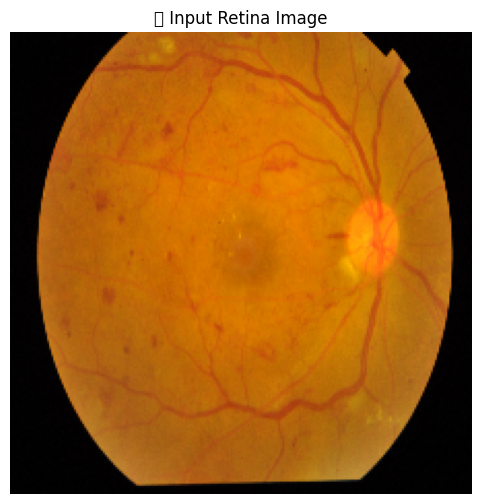


🔍 Predicted Lesion Counts:
Abnormal_vein_Elsewhere_NVE: 0
Abnormal_vein_IRMA       : 0
Abnormal_vein_Optic_Disk_NVD: 0
Cotton_Wool_Spots        : 0
Exudates                 : 0
Fibrosis                 : 0
Hemorrhage_droplets      : 1
Microaneurysms           : 0
Vitrous_Hemorrhage       : 0


In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Set directories and constants
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
CLASS_NAMES = sorted(os.listdir(MASK_DIR))
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(CLASS_NAMES)

def predict_counts_from_image(image_path):
    # --- Step 1: Load and preprocess image ---
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)  # shape: (1, 224, 224, 3)

    # --- Step 2: Prepare dummy second input ---
    second_input_shape = model.inputs[1].shape  # e.g., (None, 224, 224, 1)
    dummy_second_input = np.zeros((1,) + tuple(second_input_shape[1:]), dtype=np.float32)

    # --- Step 3: Make prediction ---
    preds = model.predict([img_input, dummy_second_input])[0]  # shape: (9,)
    preds_rounded = np.round(preds).astype(int)

    # --- Step 4: Show image and results ---
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("🖼 Input Retina Image")
    plt.show()

    print("\n🔍 Predicted Lesion Counts:")
    for cls, count in zip(CLASS_NAMES, preds_rounded):
        print(f"{cls:25}: {count}")

# --- Run it on a sample image ---
predict_counts_from_image('/content/IM002721.JPG')


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


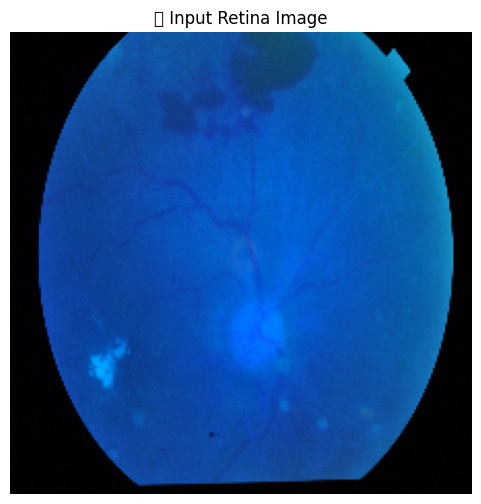


🔍 Predicted Lesion Counts:
Abnormal_vein_Elsewhere_NVE: 3
Abnormal_vein_IRMA       : 0
Abnormal_vein_Optic_Disk_NVD: 0
Cotton_Wool_Spots        : 0
Exudates                 : 0
Fibrosis                 : 0
Hemorrhage_droplets      : 20
Microaneurysms           : 10
Vitrous_Hemorrhage       : 0


In [ ]:
predict_counts_from_image('/content/IM002721.JPG')


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.measure import label
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Configuration
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
CLASS_NAMES = sorted(os.listdir(MASK_DIR))
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(CLASS_NAMES)

# Load and preprocess image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img = cv2.resize(img, IMAGE_SIZE)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img / 255.0

# Load corresponding masks and count lesions
def load_mask_and_count(image_id):
    base_id = os.path.splitext(image_id)[0]
    counts = []

    for cls in CLASS_NAMES:
        found = False
        class_folder = os.path.join(MASK_DIR, cls)

        for fname in os.listdir(class_folder):
            if base_id in fname and fname.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                mask_path = os.path.join(class_folder, fname)
                m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    m = cv2.resize(m, IMAGE_SIZE)
                    m = (m > 10).astype(np.uint8)
                    count = label(m).max()
                    counts.append(count)
                    found = True
                    break
        if not found:
            counts.append(0)  # No mask found

    return counts

# Load dataset
images = []
counts = []

print("🔄 Loading images and masks...")
for image_id in os.listdir(IMAGE_DIR):
    if not image_id.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        continue
    try:
        img = load_image(os.path.join(IMAGE_DIR, image_id))
        count_vector = load_mask_and_count(image_id)
        if sum(count_vector) == 0:
            continue  # Skip if no lesions detected
        images.append(img)
        counts.append(count_vector)
    except Exception as e:
        print(f"⚠️ Skipping {image_id}: {e}")
        continue

X = np.array(images, dtype=np.float32)
Y = np.array(counts, dtype=np.float32)

# Split dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build model
def build_counting_model(input_shape=(224, 224, 3), num_outputs=NUM_CLASSES):
    image_input = Input(shape=input_shape)
    base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=image_input)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_outputs)(x)
    output = ReLU()(output)  # Ensures non-negative predictions
    return Model(inputs=image_input, outputs=output)

model = build_counting_model()

# Compile
model.compile(optimizer=Adam(1e-4), loss=MeanSquaredError(), metrics=['mae'])

# Train
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

print("🚀 Training model...")
model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop]
)

# Predict and evaluate
Y_pred = model.predict(X_val)
Y_pred_rounded = np.round(Y_pred)

print("\n📊 Per-Class RMSE (Root Mean Squared Error):")
for i, class_name in enumerate(CLASS_NAMES):
    rmse = np.sqrt(mean_squared_error(Y_val[:, i], Y_pred[:, i]))
    print(f"{class_name:25}: RMSE = {rmse:.2f}")

print("\n🖼 Sample Prediction vs Ground Truth:")
for i in range(min(3, len(Y_val))):
    print(f"\nImage {i+1}")
    print("Predicted :", dict(zip(CLASS_NAMES, Y_pred_rounded[i].astype(int))))
    print("Actual    :", dict(zip(CLASS_NAMES, Y_val[i].astype(int))))


🔄 Loading images and masks...
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
🚀 Training model...
Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 710s 6s/step - loss: 619.9450 - mae: 8.0143 - val_loss: 587.2929 - val_mae: 7.9011
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - loss: 253.1434 - mae: 5.8980 - val_loss: 380.5412 - val_mae: 6.8241
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - loss: 229.3289 - mae: 5.9004 - val_loss: 388.7998 - val_mae: 6.9089
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - loss: 171.7683 - mae: 5.3055 - val_loss: 366.5407 - val_mae: 6.7916
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - loss: 158.4810 - mae: 5.1556 - val_loss: 191.4779 - val_mae: 5.1815
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - loss: 140.0112 - mae: 4.8237 - val_loss: 290.4051 - val_mae: 6.2062
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - loss: 150.6033 - mae: 5.0272 - val_loss: 193.3509 - val_mae: 5.0100
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16

In [ ]:
model_save_path = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/retina_multilabel_model_Countdown.h5'
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/retina_multilabel_model_Countdown.h5


🔄 Loading images and masks...


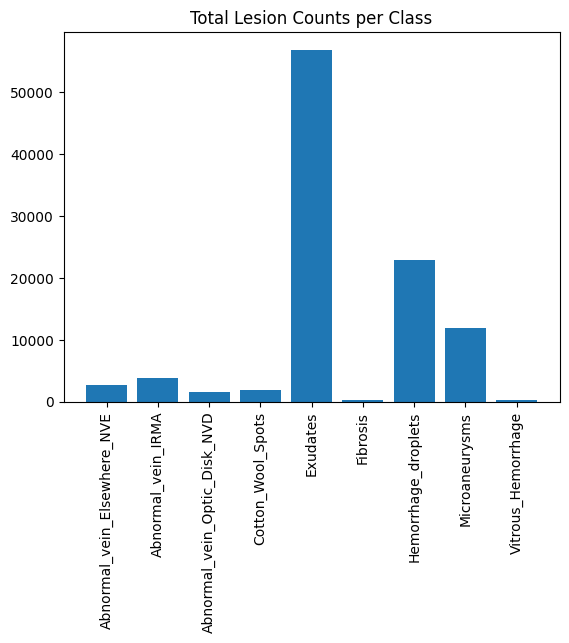

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
🚀 Training model...
Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 179s 797ms/step - loss: 7.3072 - mae: 7.4961 - val_loss: 6.3773 - val_mae: 6.5478
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 618ms/step - loss: 5.4743 - mae: 5.6380 - val_loss: 5.8035 - val_mae: 5.9591
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 606ms/step - loss: 5.2423 - mae: 5.3968 - val_loss: 5.3658 - val_mae: 5.5119
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 611ms/step - loss: 4.6988 - mae: 4.8467 - val_loss: 5.4228 - val_mae: 5.5697
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 608ms/step - loss: 4.7027 - mae: 4.8520 - val_loss: 5.1658 - val_mae: 5.3150
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 611ms/step - loss: 4.9355 - mae: 5.0886 - val_loss: 4.9441 - val_mae: 5.0903
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 605ms/step - loss: 4.7676 - mae: 4.9163 - val_loss: 5.5044 - val_mae: 5.6473
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 611ms/step - loss: 4.4177 - mae: 4.5643 - val_loss: 4

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.measure import label
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Configuration
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
CLASS_NAMES = sorted(os.listdir(MASK_DIR))
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(CLASS_NAMES)

# Load and preprocess image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img = cv2.resize(img, IMAGE_SIZE)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img / 255.0

# Load corresponding masks and count lesions
def load_mask_and_count(image_id):
    base_id = os.path.splitext(image_id)[0]
    counts = []

    for cls in CLASS_NAMES:
        found = False
        class_folder = os.path.join(MASK_DIR, cls)

        for fname in os.listdir(class_folder):
            if base_id in fname and fname.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                mask_path = os.path.join(class_folder, fname)
                m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    m = cv2.resize(m, IMAGE_SIZE)
                    m = (m > 10).astype(np.uint8)
                    count = label(m).max()
                    counts.append(count)
                    found = True
                    break
        if not found:
            counts.append(0)  # No mask found

    return counts

# Load dataset
images = []
counts = []

print("🔄 Loading images and masks...")
for image_id in os.listdir(IMAGE_DIR):
    if not image_id.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        continue
    try:
        img = load_image(os.path.join(IMAGE_DIR, image_id))
        count_vector = load_mask_and_count(image_id)
        if sum(count_vector) == 0:
            continue  # Skip if no lesions detected
        images.append(img)
        counts.append(count_vector)
    except Exception as e:
        print(f"⚠️ Skipping {image_id}: {e}")
        continue

X = np.array(images, dtype=np.float32)
Y = np.array(counts, dtype=np.float32)

# Visualize class distribution
total_counts = np.sum(Y, axis=0)
plt.bar(CLASS_NAMES, total_counts)
plt.xticks(rotation=90)
plt.title("Total Lesion Counts per Class")
plt.show()

# Split dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

# Build model
def build_counting_model(input_shape=(224, 224, 3), num_outputs=NUM_CLASSES):
    image_input = Input(shape=input_shape)
    x = data_augmentation(image_input)
    base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=x)
    x = base_model.output
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='elu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_outputs, activation='relu')(x)  # Non-negative output
    return Model(inputs=image_input, outputs=output)

model = build_counting_model()

# Compile
model.compile(optimizer=Adam(1e-4), loss=Huber(delta=1.0), metrics=['mae'])

# Train
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

print("🚀 Training model...")
model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop]
)

# Predict and evaluate
Y_pred = model.predict(X_val)
Y_pred_rounded = np.round(Y_pred)

print("\n📊 Per-Class RMSE (Root Mean Squared Error):")
for i, class_name in enumerate(CLASS_NAMES):
    rmse = np.sqrt(mean_squared_error(Y_val[:, i], Y_pred[:, i]))
    print(f"{class_name:25}: RMSE = {rmse:.2f}")

print("\n🖼 Sample Prediction vs Ground Truth:")
for i in range(min(3, len(Y_val))):
    print(f"\nImage {i+1}")
    print("Predicted :", dict(zip(CLASS_NAMES, Y_pred_rounded[i].astype(int))))
    print("Actual    :", dict(zip(CLASS_NAMES, Y_val[i].astype(int))))


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.measure import label
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Config
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
CLASS_NAMES = sorted(os.listdir(MASK_DIR))
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(CLASS_NAMES)

# Augmentation
def augment_image(img):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_brightness(img, max_delta=0.1)
    return img

# Load image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img = cv2.resize(img, IMAGE_SIZE)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img / 255.0

# Load masks and count
def load_mask_and_count(image_id):
    base_id = os.path.splitext(image_id)[0]
    counts = []

    for cls in CLASS_NAMES:
        found = False
        class_folder = os.path.join(MASK_DIR, cls)

        for fname in os.listdir(class_folder):
            if base_id in fname and fname.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                mask_path = os.path.join(class_folder, fname)
                m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    m = cv2.resize(m, IMAGE_SIZE)
                    m = (m > 10).astype(np.uint8)
                    count = label(m).max()
                    counts.append(count)
                    found = True
                    break
        if not found:
            counts.append(0)
    return counts

# Load dataset
images = []
counts = []
image_ids = []

print("🔄 Loading images and masks...")
for image_id in os.listdir(IMAGE_DIR):
    if not image_id.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        continue
    try:
        img = load_image(os.path.join(IMAGE_DIR, image_id))
        count_vector = load_mask_and_count(image_id)
        if sum(count_vector) == 0:
            continue
        images.append(img)
        counts.append(count_vector)
        image_ids.append(image_id)
    except Exception as e:
        print(f"⚠️ Skipping {image_id}: {e}")

X = np.array(images, dtype=np.float32)
Y = np.array(counts, dtype=np.float32)

# Split
X_train, X_val, Y_train, Y_val, ids_train, ids_val = train_test_split(
    X, Y, image_ids, test_size=0.2, random_state=42
)

# Augment training set
X_train_aug = tf.stack([augment_image(img) for img in tf.convert_to_tensor(X_train)])
X_train = X_train_aug.numpy()

# Build model
def build_model(input_shape=(224, 224, 3), num_outputs=NUM_CLASSES):
    inp = Input(shape=input_shape)
    base = DenseNet201(include_top=False, weights='imagenet', input_tensor=inp)
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_outputs)(x)
    out = ReLU()(out)
    return Model(inputs=inp, outputs=out)

model = build_model()
model.compile(optimizer=Adam(1e-4), loss=MeanSquaredError(), metrics=['mae'])
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

print("🚀 Training...")
model.fit(X_train, Y_train,
          validation_data=(X_val, Y_val),
          epochs=30, batch_size=16,
          callbacks=[early_stop])

# DenseNet prediction
Y_pred_densenet = model.predict(X_val)

# Mask-based counts (U-Net simulated via label counting)
Y_pred_mask = []
for image_id in ids_val:
    mask_counts = load_mask_and_count(image_id)
    Y_pred_mask.append(mask_counts)
Y_pred_mask = np.array(Y_pred_mask, dtype=np.float32)

# Ensemble prediction
Y_pred_ensemble = (Y_pred_densenet + Y_pred_mask) / 2

# Evaluate
print("\n📊 RMSE (DenseNet only):")
for i, name in enumerate(CLASS_NAMES):
    rmse = np.sqrt(mean_squared_error(Y_val[:, i], Y_pred_densenet[:, i]))
    print(f"{name:25}: RMSE = {rmse:.2f}")

print("\n📊 RMSE (Mask-based only):")
for i, name in enumerate(CLASS_NAMES):
    rmse = np.sqrt(mean_squared_error(Y_val[:, i], Y_pred_mask[:, i]))
    print(f"{name:25}: RMSE = {rmse:.2f}")

print("\n📊 RMSE (Ensembled):")
for i, name in enumerate(CLASS_NAMES):
    rmse = np.sqrt(mean_squared_error(Y_val[:, i], Y_pred_ensemble[:, i]))
    print(f"{name:25}: RMSE = {rmse:.2f}")

# Display samples
print("\n🖼 Sample Predictions:")
for i in range(min(3, len(Y_val))):
    print(f"\nImage {i+1} ({ids_val[i]})")
    print("DenseNet   :", dict(zip(CLASS_NAMES, np.round(Y_pred_densenet[i]).astype(int))))
    print("Mask Count :", dict(zip(CLASS_NAMES, np.round(Y_pred_mask[i]).astype(int))))
    print("Ensembled  :", dict(zip(CLASS_NAMES, np.round(Y_pred_ensemble[i]).astype(int))))
    print("Ground Truth:", dict(zip(CLASS_NAMES, Y_val[i].astype(int))))


🔄 Loading images and masks...
🚀 Training...
Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 736s 6s/step - loss: 689.0775 - mae: 8.1303 - val_loss: 559.9721 - val_mae: 7.9397
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 288ms/step - loss: 381.8665 - mae: 6.7408 - val_loss: 364.6026 - val_mae: 6.7849
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step - loss: 263.4779 - mae: 6.1204 - val_loss: 393.1732 - val_mae: 7.0431
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - loss: 235.6706 - mae: 5.9177 - val_loss: 304.3132 - val_mae: 6.3846
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - loss: 217.2858 - mae: 5.5780 - val_loss: 274.0809 - val_mae: 6.1095
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 257ms/step - loss: 222.1283 - mae: 5.8067 - val_loss: 294.2687 - val_mae: 6.3134
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - loss: 213.2003 - mae: 5.6509 - val_loss: 247.5918 - val_mae: 5.5848
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - loss: 221.1490 - mae: 5.7676 - val_loss: 2

In [ ]:
import os, cv2, numpy as np
from skimage.measure import label
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import albumentations as A

# --- Config ---
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
IMAGE_SIZE = (224, 224)
CLASS_NAMES = sorted(os.listdir(MASK_DIR))
NUM_CLASSES = len(CLASS_NAMES)

# --- Augmentation ---
augment = A.Compose([
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Rotate(limit=15),
    A.Resize(*IMAGE_SIZE)
])

def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = augment(image=img)['image']
    return img / 255.0

def load_mask_and_count(image_id):
    base_id = os.path.splitext(image_id)[0]
    counts = []
    for cls in CLASS_NAMES:
        found = False
        for fname in os.listdir(os.path.join(MASK_DIR, cls)):
            if base_id in fname:
                m = cv2.imread(os.path.join(MASK_DIR, cls, fname), 0)
                m = cv2.resize(m, IMAGE_SIZE)
                m = (m > 10).astype(np.uint8)
                counts.append(label(m).max())
                found = True
                break
        if not found:
            counts.append(0)
    return counts

# --- Load Dataset ---
images, counts = [], []
for img_id in os.listdir(IMAGE_DIR):
    if img_id.lower().endswith(('jpg', 'png', 'jpeg')):
        try:
            img = load_image(os.path.join(IMAGE_DIR, img_id))
            count = load_mask_and_count(img_id)
            if sum(count) > 0:
                images.append(img)
                counts.append(count)
        except Exception as e:
            print(f"Skipping {img_id}: {e}")

X, Y = np.array(images), np.array(counts)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

# --- DenseNet201 Model ---
def build_densenet_model():
    inp = Input(shape=(224, 224, 3))
    base = DenseNet201(include_top=False, weights='imagenet', input_tensor=inp)
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    out = ReLU()(Dense(NUM_CLASSES)(Dropout(0.3)(x)))
    return Model(inputs=inp, outputs=out)

densenet_model = build_densenet_model()
densenet_model.compile(optimizer=Adam(1e-4), loss=MeanSquaredError())
densenet_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=16, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

# --- U-Net Model ---
def build_unet(input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    inputs = Input(input_shape)
    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D()(c2)
    # Bottleneck
    b = Conv2D(128, 3, activation='relu', padding='same')(p2)
    # Decoder
    u1 = UpSampling2D()(b)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(u1)
    u2 = UpSampling2D()(c3)
    c4 = Conv2D(32, 3, activation='relu', padding='same')(u2)
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(c4)
    return Model(inputs, outputs)

unet_model = build_unet()
unet_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy')
# Assume X_masks is your segmentation target of shape (N, 224, 224, NUM_CLASSES)
# unet_model.fit(X_train, X_masks_train, validation_data=(X_val, X_masks_val), ...)

# --- Ensemble Prediction ---
Y_densenet = densenet_model.predict(X_val)

# Use U-Net predictions (assume you have per-class masks)
def count_from_unet_masks(mask_preds):
    counts = []
    for m in mask_preds:
        count = [label((m[..., i] > 0.5).astype(np.uint8)).max() for i in range(NUM_CLASSES)]
        counts.append(count)
    return np.array(counts)

# Sample placeholder:
mask_preds = unet_model.predict(X_val)
Y_unet = count_from_unet_masks(mask_preds)

# Final Ensemble
Y_ensemble = (Y_densenet + Y_unet) / 2

# For now, evaluate DenseNet alone
print("\n📊 Per-Class RMSE:")
for i, cls in enumerate(CLASS_NAMES):
    rmse = np.sqrt(mean_squared_error(Y_val[:, i], Y_ensemble[:, i]))
    print(f"{cls:25}: RMSE = {rmse:.2f}")



Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 697s 6s/step - loss: 675.8425 - val_loss: 456.1507
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 294ms/step - loss: 295.0965 - val_loss: 519.5374
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - loss: 216.1952 - val_loss: 300.7614
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 252ms/step - loss: 175.4821 - val_loss: 275.2313
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - loss: 175.8602 - val_loss: 307.9742
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step - loss: 136.7712 - val_loss: 262.5904
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - loss: 148.5155 - val_loss: 264.7878
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - loss: 131.8612 - val_loss: 261.9852
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 257ms/step - loss: 135.9550 - val_loss: 199.2052
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 257ms/step - loss: 122.2954 - val_loss: 197.5057
Epoch 11/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - loss: 114.3241 - val_loss: 238.9657

In [ ]:
mask_preds = unet_model.predict(X_val)
Y_unet = count_from_unet_masks(mask_preds)

# Final Ensemble
Y_ensemble = (Y_densenet + Y_unet) / 2

# For now, evaluate DenseNet alone
print("\n📊 Per-Class RMSE:")
for i, cls in enumerate(CLASS_NAMES):
    rmse = np.sqrt(mean_squared_error(Y_val[:, i], Y_unet[:, i]))
    print(f"{cls:25}: RMSE = {rmse:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step

📊 Per-Class RMSE:
Abnormal_vein_Elsewhere_NVE: RMSE = 95.85
Abnormal_vein_IRMA       : RMSE = 27.55
Abnormal_vein_Optic_Disk_NVD: RMSE = 97.38
Cotton_Wool_Spots        : RMSE = 147.93
Exudates                 : RMSE = 146.44
Fibrosis                 : RMSE = 183.52
Hemorrhage_droplets      : RMSE = 171.58
Microaneurysms           : RMSE = 118.66
Vitrous_Hemorrhage       : RMSE = 162.59


⚠️ Not enough samples for class 'Vitrous_Hemorrhage' to compute ROC.
⚠️ Not enough samples for class 'Vitrous_Hemorrhage' to compute ROC.
⚠️ Not enough samples for class 'Vitrous_Hemorrhage' to compute ROC.
⚠️ Not enough samples for class 'Vitrous_Hemorrhage' to compute ROC.
⚠️ Not enough samples for class 'Vitrous_Hemorrhage' to compute ROC.
⚠️ Not enough samples for class 'Vitrous_Hemorrhage' to compute ROC.
⚠️ Not enough samples for class 'Vitrous_Hemorrhage' to compute ROC.
⚠️ Not enough samples for class 'Vitrous_Hemorrhage' to compute ROC.
⚠️ Not enough samples for class 'Vitrous_Hemorrhage' to compute ROC.


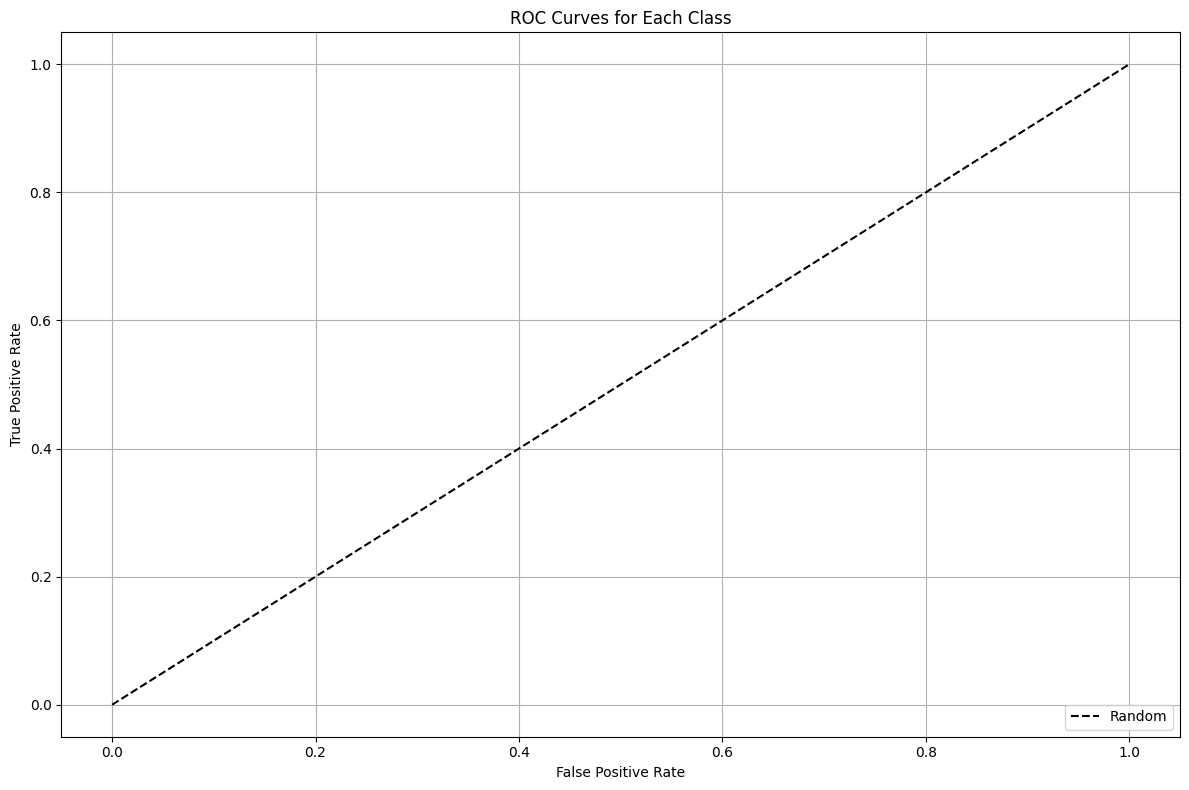

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 8))
for i, cls in enumerate(CLASS_NAMES):
    try:
        fpr, tpr, _ = roc_curve(Y_val[:, i], mask_preds[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")
    except ValueError:
        print(f"⚠️ Not enough samples for class '{class_name}' to compute ROC.")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
# --- Config ---
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
IMAGE_SIZE = (224, 224)
CLASS_NAMES = sorted(os.listdir(MASK_DIR))
NUM_CLASSES = len(CLASS_NAMES)

# --- Augmentation ---
augment = A.Compose([
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Rotate(limit=15),
    A.Resize(*IMAGE_SIZE)
])

def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = augment(image=img)['image']
    return img / 255.0

def load_mask_and_count(image_id):
    base_id = os.path.splitext(image_id)[0]
    counts = []
    for cls in CLASS_NAMES:
        found = False
        for fname in os.listdir(os.path.join(MASK_DIR, cls)):
            if base_id in fname:
                m = cv2.imread(os.path.join(MASK_DIR, cls, fname), 0)
                m = cv2.resize(m, IMAGE_SIZE)
                m = (m > 10).astype(np.uint8)
                counts.append(label(m).max())
                found = True
                break
        if not found:
            counts.append(0)
    return counts

# --- Load Dataset ---
images, counts = [], []
for img_id in os.listdir(IMAGE_DIR):
    if img_id.lower().endswith(('jpg', 'png', 'jpeg')):
        try:
            img = load_image(os.path.join(IMAGE_DIR, img_id))
            count = load_mask_and_count(img_id)
            if sum(count) > 0:
                images.append(img)
                counts.append(count)
        except Exception as e:
            print(f"Skipping {img_id}: {e}")

X, Y = np.array(images), np.array(counts)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
from tensorflow.keras import layers, models, applications, Input

def convolution_block(x, filters, kernel_size, dilation_rate):
    x = layers.Conv2D(filters, kernel_size, padding="same", dilation_rate=dilation_rate, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    return layers.Activation("relu")(x)

def ASPP(x, filters=256):
    input_shape = x.shape
    h, w = input_shape[1], input_shape[2]

    y1 = convolution_block(x, filters, 1, 1)
    y2 = convolution_block(x, filters, 3, 6)
    y3 = convolution_block(x, filters, 3, 12)
    y4 = convolution_block(x, filters, 3, 18)

    y5 = layers.GlobalAveragePooling2D()(x)
    y5 = layers.Reshape((1, 1, y5.shape[-1]))(y5)
    y5 = layers.Conv2D(filters, 1, use_bias=False)(y5)
    y5 = layers.BatchNormalization()(y5)
    y5 = layers.Activation("relu")(y5)
    y5 = layers.UpSampling2D(size=(h, w), interpolation="bilinear")(y5)

    y = layers.Concatenate()([y1, y2, y3, y4, y5])
    y = layers.Conv2D(filters, 1, use_bias=False)(y)
    y = layers.BatchNormalization()(y)
    return layers.Activation("relu")(y)

def DeepLabV3Plus(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    base_model = applications.DenseNet201(include_top=False, weights="imagenet", input_tensor=inputs)
    x = base_model.output

    x = ASPP(x, 256)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Decoder
    skip = base_model.get_layer("conv1/relu").output  # DenseNet initial conv layer
    skip = layers.Conv2D(48, 1, padding="same", use_bias=False)(skip)
    skip = layers.BatchNormalization()(skip)
    skip = layers.Activation("relu")(skip)

    x = layers.Concatenate()([x, skip])
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="sigmoid")(x)

    return models.Model(inputs, outputs)

model = DeepLabV3Plus()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Example
history = model.fit(X_train, validation_data=X_val, epochs=30)





ValueError: No such layer: conv1/relu. Existing layers are: ['input_layer_8', 'zero_padding2d_6', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'zero_padding2d_7', 'pool1', 'conv2_block1_0_bn', 'conv2_block1_0_relu', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_concat', 'conv2_block2_0_bn', 'conv2_block2_0_relu', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_concat', 'conv2_block3_0_bn', 'conv2_block3_0_relu', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_concat', 'conv2_block4_0_bn', 'conv2_block4_0_relu', 'conv2_block4_1_conv', 'conv2_block4_1_bn', 'conv2_block4_1_relu', 'conv2_block4_2_conv', 'conv2_block4_concat', 'conv2_block5_0_bn', 'conv2_block5_0_relu', 'conv2_block5_1_conv', 'conv2_block5_1_bn', 'conv2_block5_1_relu', 'conv2_block5_2_conv', 'conv2_block5_concat', 'conv2_block6_0_bn', 'conv2_block6_0_relu', 'conv2_block6_1_conv', 'conv2_block6_1_bn', 'conv2_block6_1_relu', 'conv2_block6_2_conv', 'conv2_block6_concat', 'pool2_bn', 'pool2_relu', 'pool2_conv', 'pool2_pool', 'conv3_block1_0_bn', 'conv3_block1_0_relu', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_concat', 'conv3_block2_0_bn', 'conv3_block2_0_relu', 'conv3_block2_1_conv', 'conv3_block2_1_bn', 'conv3_block2_1_relu', 'conv3_block2_2_conv', 'conv3_block2_concat', 'conv3_block3_0_bn', 'conv3_block3_0_relu', 'conv3_block3_1_conv', 'conv3_block3_1_bn', 'conv3_block3_1_relu', 'conv3_block3_2_conv', 'conv3_block3_concat', 'conv3_block4_0_bn', 'conv3_block4_0_relu', 'conv3_block4_1_conv', 'conv3_block4_1_bn', 'conv3_block4_1_relu', 'conv3_block4_2_conv', 'conv3_block4_concat', 'conv3_block5_0_bn', 'conv3_block5_0_relu', 'conv3_block5_1_conv', 'conv3_block5_1_bn', 'conv3_block5_1_relu', 'conv3_block5_2_conv', 'conv3_block5_concat', 'conv3_block6_0_bn', 'conv3_block6_0_relu', 'conv3_block6_1_conv', 'conv3_block6_1_bn', 'conv3_block6_1_relu', 'conv3_block6_2_conv', 'conv3_block6_concat', 'conv3_block7_0_bn', 'conv3_block7_0_relu', 'conv3_block7_1_conv', 'conv3_block7_1_bn', 'conv3_block7_1_relu', 'conv3_block7_2_conv', 'conv3_block7_concat', 'conv3_block8_0_bn', 'conv3_block8_0_relu', 'conv3_block8_1_conv', 'conv3_block8_1_bn', 'conv3_block8_1_relu', 'conv3_block8_2_conv', 'conv3_block8_concat', 'conv3_block9_0_bn', 'conv3_block9_0_relu', 'conv3_block9_1_conv', 'conv3_block9_1_bn', 'conv3_block9_1_relu', 'conv3_block9_2_conv', 'conv3_block9_concat', 'conv3_block10_0_bn', 'conv3_block10_0_relu', 'conv3_block10_1_conv', 'conv3_block10_1_bn', 'conv3_block10_1_relu', 'conv3_block10_2_conv', 'conv3_block10_concat', 'conv3_block11_0_bn', 'conv3_block11_0_relu', 'conv3_block11_1_conv', 'conv3_block11_1_bn', 'conv3_block11_1_relu', 'conv3_block11_2_conv', 'conv3_block11_concat', 'conv3_block12_0_bn', 'conv3_block12_0_relu', 'conv3_block12_1_conv', 'conv3_block12_1_bn', 'conv3_block12_1_relu', 'conv3_block12_2_conv', 'conv3_block12_concat', 'pool3_bn', 'pool3_relu', 'pool3_conv', 'pool3_pool', 'conv4_block1_0_bn', 'conv4_block1_0_relu', 'conv4_block1_1_conv', 'conv4_block1_1_bn', 'conv4_block1_1_relu', 'conv4_block1_2_conv', 'conv4_block1_concat', 'conv4_block2_0_bn', 'conv4_block2_0_relu', 'conv4_block2_1_conv', 'conv4_block2_1_bn', 'conv4_block2_1_relu', 'conv4_block2_2_conv', 'conv4_block2_concat', 'conv4_block3_0_bn', 'conv4_block3_0_relu', 'conv4_block3_1_conv', 'conv4_block3_1_bn', 'conv4_block3_1_relu', 'conv4_block3_2_conv', 'conv4_block3_concat', 'conv4_block4_0_bn', 'conv4_block4_0_relu', 'conv4_block4_1_conv', 'conv4_block4_1_bn', 'conv4_block4_1_relu', 'conv4_block4_2_conv', 'conv4_block4_concat', 'conv4_block5_0_bn', 'conv4_block5_0_relu', 'conv4_block5_1_conv', 'conv4_block5_1_bn', 'conv4_block5_1_relu', 'conv4_block5_2_conv', 'conv4_block5_concat', 'conv4_block6_0_bn', 'conv4_block6_0_relu', 'conv4_block6_1_conv', 'conv4_block6_1_bn', 'conv4_block6_1_relu', 'conv4_block6_2_conv', 'conv4_block6_concat', 'conv4_block7_0_bn', 'conv4_block7_0_relu', 'conv4_block7_1_conv', 'conv4_block7_1_bn', 'conv4_block7_1_relu', 'conv4_block7_2_conv', 'conv4_block7_concat', 'conv4_block8_0_bn', 'conv4_block8_0_relu', 'conv4_block8_1_conv', 'conv4_block8_1_bn', 'conv4_block8_1_relu', 'conv4_block8_2_conv', 'conv4_block8_concat', 'conv4_block9_0_bn', 'conv4_block9_0_relu', 'conv4_block9_1_conv', 'conv4_block9_1_bn', 'conv4_block9_1_relu', 'conv4_block9_2_conv', 'conv4_block9_concat', 'conv4_block10_0_bn', 'conv4_block10_0_relu', 'conv4_block10_1_conv', 'conv4_block10_1_bn', 'conv4_block10_1_relu', 'conv4_block10_2_conv', 'conv4_block10_concat', 'conv4_block11_0_bn', 'conv4_block11_0_relu', 'conv4_block11_1_conv', 'conv4_block11_1_bn', 'conv4_block11_1_relu', 'conv4_block11_2_conv', 'conv4_block11_concat', 'conv4_block12_0_bn', 'conv4_block12_0_relu', 'conv4_block12_1_conv', 'conv4_block12_1_bn', 'conv4_block12_1_relu', 'conv4_block12_2_conv', 'conv4_block12_concat', 'conv4_block13_0_bn', 'conv4_block13_0_relu', 'conv4_block13_1_conv', 'conv4_block13_1_bn', 'conv4_block13_1_relu', 'conv4_block13_2_conv', 'conv4_block13_concat', 'conv4_block14_0_bn', 'conv4_block14_0_relu', 'conv4_block14_1_conv', 'conv4_block14_1_bn', 'conv4_block14_1_relu', 'conv4_block14_2_conv', 'conv4_block14_concat', 'conv4_block15_0_bn', 'conv4_block15_0_relu', 'conv4_block15_1_conv', 'conv4_block15_1_bn', 'conv4_block15_1_relu', 'conv4_block15_2_conv', 'conv4_block15_concat', 'conv4_block16_0_bn', 'conv4_block16_0_relu', 'conv4_block16_1_conv', 'conv4_block16_1_bn', 'conv4_block16_1_relu', 'conv4_block16_2_conv', 'conv4_block16_concat', 'conv4_block17_0_bn', 'conv4_block17_0_relu', 'conv4_block17_1_conv', 'conv4_block17_1_bn', 'conv4_block17_1_relu', 'conv4_block17_2_conv', 'conv4_block17_concat', 'conv4_block18_0_bn', 'conv4_block18_0_relu', 'conv4_block18_1_conv', 'conv4_block18_1_bn', 'conv4_block18_1_relu', 'conv4_block18_2_conv', 'conv4_block18_concat', 'conv4_block19_0_bn', 'conv4_block19_0_relu', 'conv4_block19_1_conv', 'conv4_block19_1_bn', 'conv4_block19_1_relu', 'conv4_block19_2_conv', 'conv4_block19_concat', 'conv4_block20_0_bn', 'conv4_block20_0_relu', 'conv4_block20_1_conv', 'conv4_block20_1_bn', 'conv4_block20_1_relu', 'conv4_block20_2_conv', 'conv4_block20_concat', 'conv4_block21_0_bn', 'conv4_block21_0_relu', 'conv4_block21_1_conv', 'conv4_block21_1_bn', 'conv4_block21_1_relu', 'conv4_block21_2_conv', 'conv4_block21_concat', 'conv4_block22_0_bn', 'conv4_block22_0_relu', 'conv4_block22_1_conv', 'conv4_block22_1_bn', 'conv4_block22_1_relu', 'conv4_block22_2_conv', 'conv4_block22_concat', 'conv4_block23_0_bn', 'conv4_block23_0_relu', 'conv4_block23_1_conv', 'conv4_block23_1_bn', 'conv4_block23_1_relu', 'conv4_block23_2_conv', 'conv4_block23_concat', 'conv4_block24_0_bn', 'conv4_block24_0_relu', 'conv4_block24_1_conv', 'conv4_block24_1_bn', 'conv4_block24_1_relu', 'conv4_block24_2_conv', 'conv4_block24_concat', 'conv4_block25_0_bn', 'conv4_block25_0_relu', 'conv4_block25_1_conv', 'conv4_block25_1_bn', 'conv4_block25_1_relu', 'conv4_block25_2_conv', 'conv4_block25_concat', 'conv4_block26_0_bn', 'conv4_block26_0_relu', 'conv4_block26_1_conv', 'conv4_block26_1_bn', 'conv4_block26_1_relu', 'conv4_block26_2_conv', 'conv4_block26_concat', 'conv4_block27_0_bn', 'conv4_block27_0_relu', 'conv4_block27_1_conv', 'conv4_block27_1_bn', 'conv4_block27_1_relu', 'conv4_block27_2_conv', 'conv4_block27_concat', 'conv4_block28_0_bn', 'conv4_block28_0_relu', 'conv4_block28_1_conv', 'conv4_block28_1_bn', 'conv4_block28_1_relu', 'conv4_block28_2_conv', 'conv4_block28_concat', 'conv4_block29_0_bn', 'conv4_block29_0_relu', 'conv4_block29_1_conv', 'conv4_block29_1_bn', 'conv4_block29_1_relu', 'conv4_block29_2_conv', 'conv4_block29_concat', 'conv4_block30_0_bn', 'conv4_block30_0_relu', 'conv4_block30_1_conv', 'conv4_block30_1_bn', 'conv4_block30_1_relu', 'conv4_block30_2_conv', 'conv4_block30_concat', 'conv4_block31_0_bn', 'conv4_block31_0_relu', 'conv4_block31_1_conv', 'conv4_block31_1_bn', 'conv4_block31_1_relu', 'conv4_block31_2_conv', 'conv4_block31_concat', 'conv4_block32_0_bn', 'conv4_block32_0_relu', 'conv4_block32_1_conv', 'conv4_block32_1_bn', 'conv4_block32_1_relu', 'conv4_block32_2_conv', 'conv4_block32_concat', 'conv4_block33_0_bn', 'conv4_block33_0_relu', 'conv4_block33_1_conv', 'conv4_block33_1_bn', 'conv4_block33_1_relu', 'conv4_block33_2_conv', 'conv4_block33_concat', 'conv4_block34_0_bn', 'conv4_block34_0_relu', 'conv4_block34_1_conv', 'conv4_block34_1_bn', 'conv4_block34_1_relu', 'conv4_block34_2_conv', 'conv4_block34_concat', 'conv4_block35_0_bn', 'conv4_block35_0_relu', 'conv4_block35_1_conv', 'conv4_block35_1_bn', 'conv4_block35_1_relu', 'conv4_block35_2_conv', 'conv4_block35_concat', 'conv4_block36_0_bn', 'conv4_block36_0_relu', 'conv4_block36_1_conv', 'conv4_block36_1_bn', 'conv4_block36_1_relu', 'conv4_block36_2_conv', 'conv4_block36_concat', 'conv4_block37_0_bn', 'conv4_block37_0_relu', 'conv4_block37_1_conv', 'conv4_block37_1_bn', 'conv4_block37_1_relu', 'conv4_block37_2_conv', 'conv4_block37_concat', 'conv4_block38_0_bn', 'conv4_block38_0_relu', 'conv4_block38_1_conv', 'conv4_block38_1_bn', 'conv4_block38_1_relu', 'conv4_block38_2_conv', 'conv4_block38_concat', 'conv4_block39_0_bn', 'conv4_block39_0_relu', 'conv4_block39_1_conv', 'conv4_block39_1_bn', 'conv4_block39_1_relu', 'conv4_block39_2_conv', 'conv4_block39_concat', 'conv4_block40_0_bn', 'conv4_block40_0_relu', 'conv4_block40_1_conv', 'conv4_block40_1_bn', 'conv4_block40_1_relu', 'conv4_block40_2_conv', 'conv4_block40_concat', 'conv4_block41_0_bn', 'conv4_block41_0_relu', 'conv4_block41_1_conv', 'conv4_block41_1_bn', 'conv4_block41_1_relu', 'conv4_block41_2_conv', 'conv4_block41_concat', 'conv4_block42_0_bn', 'conv4_block42_0_relu', 'conv4_block42_1_conv', 'conv4_block42_1_bn', 'conv4_block42_1_relu', 'conv4_block42_2_conv', 'conv4_block42_concat', 'conv4_block43_0_bn', 'conv4_block43_0_relu', 'conv4_block43_1_conv', 'conv4_block43_1_bn', 'conv4_block43_1_relu', 'conv4_block43_2_conv', 'conv4_block43_concat', 'conv4_block44_0_bn', 'conv4_block44_0_relu', 'conv4_block44_1_conv', 'conv4_block44_1_bn', 'conv4_block44_1_relu', 'conv4_block44_2_conv', 'conv4_block44_concat', 'conv4_block45_0_bn', 'conv4_block45_0_relu', 'conv4_block45_1_conv', 'conv4_block45_1_bn', 'conv4_block45_1_relu', 'conv4_block45_2_conv', 'conv4_block45_concat', 'conv4_block46_0_bn', 'conv4_block46_0_relu', 'conv4_block46_1_conv', 'conv4_block46_1_bn', 'conv4_block46_1_relu', 'conv4_block46_2_conv', 'conv4_block46_concat', 'conv4_block47_0_bn', 'conv4_block47_0_relu', 'conv4_block47_1_conv', 'conv4_block47_1_bn', 'conv4_block47_1_relu', 'conv4_block47_2_conv', 'conv4_block47_concat', 'conv4_block48_0_bn', 'conv4_block48_0_relu', 'conv4_block48_1_conv', 'conv4_block48_1_bn', 'conv4_block48_1_relu', 'conv4_block48_2_conv', 'conv4_block48_concat', 'pool4_bn', 'pool4_relu', 'pool4_conv', 'pool4_pool', 'conv5_block1_0_bn', 'conv5_block1_0_relu', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_1_relu', 'conv5_block1_2_conv', 'conv5_block1_concat', 'conv5_block2_0_bn', 'conv5_block2_0_relu', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_1_relu', 'conv5_block2_2_conv', 'conv5_block2_concat', 'conv5_block3_0_bn', 'conv5_block3_0_relu', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_conv', 'conv5_block3_concat', 'conv5_block4_0_bn', 'conv5_block4_0_relu', 'conv5_block4_1_conv', 'conv5_block4_1_bn', 'conv5_block4_1_relu', 'conv5_block4_2_conv', 'conv5_block4_concat', 'conv5_block5_0_bn', 'conv5_block5_0_relu', 'conv5_block5_1_conv', 'conv5_block5_1_bn', 'conv5_block5_1_relu', 'conv5_block5_2_conv', 'conv5_block5_concat', 'conv5_block6_0_bn', 'conv5_block6_0_relu', 'conv5_block6_1_conv', 'conv5_block6_1_bn', 'conv5_block6_1_relu', 'conv5_block6_2_conv', 'conv5_block6_concat', 'conv5_block7_0_bn', 'conv5_block7_0_relu', 'conv5_block7_1_conv', 'conv5_block7_1_bn', 'conv5_block7_1_relu', 'conv5_block7_2_conv', 'conv5_block7_concat', 'conv5_block8_0_bn', 'conv5_block8_0_relu', 'conv5_block8_1_conv', 'conv5_block8_1_bn', 'conv5_block8_1_relu', 'conv5_block8_2_conv', 'conv5_block8_concat', 'conv5_block9_0_bn', 'conv5_block9_0_relu', 'conv5_block9_1_conv', 'conv5_block9_1_bn', 'conv5_block9_1_relu', 'conv5_block9_2_conv', 'conv5_block9_concat', 'conv5_block10_0_bn', 'conv5_block10_0_relu', 'conv5_block10_1_conv', 'conv5_block10_1_bn', 'conv5_block10_1_relu', 'conv5_block10_2_conv', 'conv5_block10_concat', 'conv5_block11_0_bn', 'conv5_block11_0_relu', 'conv5_block11_1_conv', 'conv5_block11_1_bn', 'conv5_block11_1_relu', 'conv5_block11_2_conv', 'conv5_block11_concat', 'conv5_block12_0_bn', 'conv5_block12_0_relu', 'conv5_block12_1_conv', 'conv5_block12_1_bn', 'conv5_block12_1_relu', 'conv5_block12_2_conv', 'conv5_block12_concat', 'conv5_block13_0_bn', 'conv5_block13_0_relu', 'conv5_block13_1_conv', 'conv5_block13_1_bn', 'conv5_block13_1_relu', 'conv5_block13_2_conv', 'conv5_block13_concat', 'conv5_block14_0_bn', 'conv5_block14_0_relu', 'conv5_block14_1_conv', 'conv5_block14_1_bn', 'conv5_block14_1_relu', 'conv5_block14_2_conv', 'conv5_block14_concat', 'conv5_block15_0_bn', 'conv5_block15_0_relu', 'conv5_block15_1_conv', 'conv5_block15_1_bn', 'conv5_block15_1_relu', 'conv5_block15_2_conv', 'conv5_block15_concat', 'conv5_block16_0_bn', 'conv5_block16_0_relu', 'conv5_block16_1_conv', 'conv5_block16_1_bn', 'conv5_block16_1_relu', 'conv5_block16_2_conv', 'conv5_block16_concat', 'conv5_block17_0_bn', 'conv5_block17_0_relu', 'conv5_block17_1_conv', 'conv5_block17_1_bn', 'conv5_block17_1_relu', 'conv5_block17_2_conv', 'conv5_block17_concat', 'conv5_block18_0_bn', 'conv5_block18_0_relu', 'conv5_block18_1_conv', 'conv5_block18_1_bn', 'conv5_block18_1_relu', 'conv5_block18_2_conv', 'conv5_block18_concat', 'conv5_block19_0_bn', 'conv5_block19_0_relu', 'conv5_block19_1_conv', 'conv5_block19_1_bn', 'conv5_block19_1_relu', 'conv5_block19_2_conv', 'conv5_block19_concat', 'conv5_block20_0_bn', 'conv5_block20_0_relu', 'conv5_block20_1_conv', 'conv5_block20_1_bn', 'conv5_block20_1_relu', 'conv5_block20_2_conv', 'conv5_block20_concat', 'conv5_block21_0_bn', 'conv5_block21_0_relu', 'conv5_block21_1_conv', 'conv5_block21_1_bn', 'conv5_block21_1_relu', 'conv5_block21_2_conv', 'conv5_block21_concat', 'conv5_block22_0_bn', 'conv5_block22_0_relu', 'conv5_block22_1_conv', 'conv5_block22_1_bn', 'conv5_block22_1_relu', 'conv5_block22_2_conv', 'conv5_block22_concat', 'conv5_block23_0_bn', 'conv5_block23_0_relu', 'conv5_block23_1_conv', 'conv5_block23_1_bn', 'conv5_block23_1_relu', 'conv5_block23_2_conv', 'conv5_block23_concat', 'conv5_block24_0_bn', 'conv5_block24_0_relu', 'conv5_block24_1_conv', 'conv5_block24_1_bn', 'conv5_block24_1_relu', 'conv5_block24_2_conv', 'conv5_block24_concat', 'conv5_block25_0_bn', 'conv5_block25_0_relu', 'conv5_block25_1_conv', 'conv5_block25_1_bn', 'conv5_block25_1_relu', 'conv5_block25_2_conv', 'conv5_block25_concat', 'conv5_block26_0_bn', 'conv5_block26_0_relu', 'conv5_block26_1_conv', 'conv5_block26_1_bn', 'conv5_block26_1_relu', 'conv5_block26_2_conv', 'conv5_block26_concat', 'conv5_block27_0_bn', 'conv5_block27_0_relu', 'conv5_block27_1_conv', 'conv5_block27_1_bn', 'conv5_block27_1_relu', 'conv5_block27_2_conv', 'conv5_block27_concat', 'conv5_block28_0_bn', 'conv5_block28_0_relu', 'conv5_block28_1_conv', 'conv5_block28_1_bn', 'conv5_block28_1_relu', 'conv5_block28_2_conv', 'conv5_block28_concat', 'conv5_block29_0_bn', 'conv5_block29_0_relu', 'conv5_block29_1_conv', 'conv5_block29_1_bn', 'conv5_block29_1_relu', 'conv5_block29_2_conv', 'conv5_block29_concat', 'conv5_block30_0_bn', 'conv5_block30_0_relu', 'conv5_block30_1_conv', 'conv5_block30_1_bn', 'conv5_block30_1_relu', 'conv5_block30_2_conv', 'conv5_block30_concat', 'conv5_block31_0_bn', 'conv5_block31_0_relu', 'conv5_block31_1_conv', 'conv5_block31_1_bn', 'conv5_block31_1_relu', 'conv5_block31_2_conv', 'conv5_block31_concat', 'conv5_block32_0_bn', 'conv5_block32_0_relu', 'conv5_block32_1_conv', 'conv5_block32_1_bn', 'conv5_block32_1_relu', 'conv5_block32_2_conv', 'conv5_block32_concat', 'bn', 'relu'].

In [ ]:
# Predict on validation set
y_true = []
y_pred = []

for x_batch, y_batch in X_val:
    preds = model.predict(x_batch)
    preds = (preds > 0.5).astype(np.uint8)
    y_true.extend(y_batch.numpy().astype(np.uint8).reshape(-1))
    y_pred.extend(preds.reshape(-1))

# Compute metrics
iou = jaccard_score(y_true, y_pred, average='binary')
dice = f1_score(y_true, y_pred, average='binary')

print(f"IoU Score: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")


In [ ]:
def visualize_predictions(dataset, model, num=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        for i in range(num):
            plt.figure(figsize=(10, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Image")

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
            plt.title("Ground Truth")

            plt.subplot(1, 3, 3)
            plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
            plt.title("Prediction")
            plt.show()


M0 and M1

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.measure import label
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, classification_report

# Configuration
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
CLASS_NAMES = sorted(os.listdir(MASK_DIR))
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(CLASS_NAMES)

# Load image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img = cv2.resize(img, IMAGE_SIZE)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img / 255.0

# Load masks and count connected lesions
def load_mask_and_count(image_id):
    base_id = os.path.splitext(image_id)[0]
    counts = []

    for cls in CLASS_NAMES:
        found = False
        possible_filenames = [
            f"{base_id}_{cls}.png",
            f"{base_id}.png",
            f"{base_id}_{cls}.jpg",
            f"{base_id}.jpg"
        ]
        for fname in possible_filenames:
            mask_path = os.path.join(MASK_DIR, cls, fname)
            if os.path.exists(mask_path):
                m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    m = cv2.resize(m, IMAGE_SIZE)
                    m = (m > 10).astype(np.uint8)
                    count = label(m).max()
                    counts.append(count)
                    found = True
                    break
        if not found:
            counts.append(0)
    return counts

# Load dataset
images = []
counts = []

for image_id in os.listdir(IMAGE_DIR):
    if not image_id.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        continue
    try:
        img = load_image(os.path.join(IMAGE_DIR, image_id))
        count_vector = load_mask_and_count(image_id)
        if sum(count_vector) == 0:
            continue  # Skip if no lesion found
        images.append(img)
        counts.append(count_vector)
    except Exception as e:
        print(f"Skipping {image_id}: {e}")
        continue

X = np.array(images, dtype=np.float32)
Y = np.array(counts, dtype=np.float32)

# Split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build model
def build_counting_model(input_shape=(224, 224, 3), num_outputs=NUM_CLASSES):
    image_input = Input(shape=input_shape)
    base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=image_input)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_outputs)(x)
    output = ReLU()(output)  # Ensure non-negative counts
    return Model(inputs=image_input, outputs=output)

model = build_counting_model()

# Compile
model.compile(optimizer=Adam(1e-4), loss=MeanSquaredError(), metrics=['mae'])

# Train
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop]
)

# Predict
Y_pred = model.predict(X_val)
Y_pred_rounded = np.round(Y_pred)

# Per-Class RMSE
print("\n📊 Per-Class RMSE (Root Mean Squared Error):")
for i, class_name in enumerate(CLASS_NAMES):
    rmse = np.sqrt(mean_squared_error(Y_val[:, i], Y_pred[:, i]))
    print(f"{class_name:25}: RMSE = {rmse:.2f}")

# ================================
# 🔍 M0 vs M1 Classification Logic
# ================================

# Find exudate index
exudate_idx = None
for i, cls in enumerate(CLASS_NAMES):
    if 'exudate' in cls.lower():
        exudate_idx = i
        break

if exudate_idx is None:
    raise ValueError("Could not find 'exudate' class in CLASS_NAMES.")

# Define M0/M1 rule
def classify_m0_m1(pred_counts, threshold=0.5):
    return ["M1" if counts[exudate_idx] > threshold else "M0" for counts in pred_counts]

# Apply M0/M1 classification
Y_pred_m0m1 = classify_m0_m1(Y_pred)
Y_true_m0m1 = classify_m0_m1(Y_val)

# Classification report
print("\n🩺 M0/M1 Classification Report:")
print(classification_report(Y_true_m0m1, Y_pred_m0m1))

# Show few samples
print("\n🖼 Sample M0/M1 Decisions:")
for i in range(3):
    print(f"\nImage {i+1}")
    print("Predicted counts :", dict(zip(CLASS_NAMES, Y_pred_rounded[i].astype(int))))
    print("Predicted M-class:", Y_pred_m0m1[i])
    print("Actual M-class   :", Y_true_m0m1[i])


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'

batch 4 segmentation

In [ ]:
import os
import shutil

# Define source and destination directories
source_dir = '/content/drive/MyDrive/segmentation masks Batch-5/separated_masks/Vitrous_Hemorrhage'
destination_dir = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks/Vitrous_Hemorrhage'

# Create the destination folder if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Define image file extensions to copy
image_extensions = ('.jpg', '.jpeg', '.png')

# Iterate through the files in the source directory
for file_name in os.listdir(source_dir):
    # Check if the file has a valid image extension
    if file_name.lower().endswith(image_extensions):
        src_file = os.path.join(source_dir, file_name)
        dst_file = os.path.join(destination_dir, file_name)

        # Check if it's a file before copying (skip directories)
        if os.path.isfile(src_file):
            try:
                shutil.copy(src_file, dst_file)
                print(f'Copied: {src_file} -> {dst_file}')
            except Exception as e:
                print(f'Error copying {src_file} to {dst_file}: {e}')


Copied: /content/drive/MyDrive/segmentation masks Batch-5/separated_masks/Abnormal_vein_Elsewhere_(NVE)/46788.png -> /content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks/Abnormal_vein_Elsewhere_(NVE)/46788.png
Copied: /content/drive/MyDrive/segmentation masks Batch-5/separated_masks/Abnormal_vein_Elsewhere_(NVE)/46784.png -> /content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks/Abnormal_vein_Elsewhere_(NVE)/46784.png
Copied: /content/drive/MyDrive/segmentation masks Batch-5/separated_masks/Abnormal_vein_Elsewhere_(NVE)/40836.png -> /content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks/Abnormal_vein_Elsewhere_(NVE)/40836.png
Copied: /content/drive/MyDrive/segmentation masks Batch-5/separated_masks/Abnormal_vein_Elsewhere_(NVE)/40837.png -> /content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks/Abnormal_vein_Elsewhere_(NVE)/40837.png
Copied: /content/drive/MyDrive/segmentation masks Batch-5/separated_masks/Abnormal_vein_

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.measure import label
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score

# Configuration
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
CLASS_NAMES = sorted(os.listdir(MASK_DIR))
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(CLASS_NAMES)

# Load image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img = cv2.resize(img, IMAGE_SIZE)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img / 255.0

# Load masks and check presence of lesions
def load_mask_and_count(image_id):
    base_id = os.path.splitext(image_id)[0]
    binary_labels = []

    for cls in CLASS_NAMES:
        found = False
        possible_filenames = [
            f"{base_id}_{cls}.png",
            f"{base_id}.png",
            f"{base_id}_{cls}.jpg",
            f"{base_id}.jpg"
        ]
        for fname in possible_filenames:
            mask_path = os.path.join(MASK_DIR, cls, fname)
            if os.path.exists(mask_path):
                m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    m = cv2.resize(m, IMAGE_SIZE)
                    m = (m > 10).astype(np.uint8)
                    count = label(m).max()
                    binary_labels.append(1 if count > 0 else 0)
                    found = True
                    break
        if not found:
            binary_labels.append(0)
    return binary_labels

# Load dataset
images = []
labels = []

for image_id in os.listdir(IMAGE_DIR):
    if not image_id.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        continue
    try:
        img = load_image(os.path.join(IMAGE_DIR, image_id))
        binary_labels = load_mask_and_count(image_id)
        images.append(img)
        labels.append(binary_labels)
    except Exception as e:
        print(f"Skipping {image_id}: {e}")
        continue

X = np.array(images, dtype=np.float32)
Y = np.array(labels, dtype=np.float32)

# Split dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build model with deep augmentation
def build_multilabel_model(input_shape=(224, 224, 3), num_outputs=NUM_CLASSES):
    image_input = Input(shape=input_shape)

    # Deep augmentation layers
    x = RandomFlip("horizontal_and_vertical")(image_input)
    x = RandomRotation(0.3)(x)
    x = RandomZoom(0.2)(x)
    x = RandomContrast(0.2)(x)

    # Base model with frozen initial layers
    base_model = DenseNet201(include_top=False, weights='imagenet')(x)

    # Additional convolutional blocks
    x = tf.keras.layers.Conv2D(1024, (3, 3), activation='swish', padding='same')(base_model)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), activation='swish', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Attention mechanism
    attention = tf.keras.layers.GlobalAveragePooling2D()(x)
    attention = tf.keras.layers.Dense(512, activation='swish')(attention)
    attention = tf.keras.layers.Dense(x.shape[-1], activation='sigmoid')(attention)
    x = tf.keras.layers.multiply([x, attention])

    # Deep dense layers with regularization
    x = GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.6)(x)

    x = tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='swish')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Multi-output layer with feature-wise attention
    output = Dense(num_outputs, activation='sigmoid')(x)

    return Model(inputs=image_input, outputs=output)

model = build_multilabel_model()

# Compile model
model.compile(
    optimizer=Adam(1e-4),
    loss=BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.AUC(name='auc', multi_label=True),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Add learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

# Extended training with checkpointing
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_ensemble.h5',
    save_best_only=True,
    monitor='val_auc',
    mode='max'
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)


# Evaluate model
Y_pred = model.predict(X_val)
Y_pred_binary = (Y_pred > 0.25).astype(int)

print("\nClassification Report:")
print(classification_report(Y_val, Y_pred_binary, target_names=CLASS_NAMES))

print("\nOverall AUC-ROC:", roc_auc_score(Y_val, Y_pred))

# Sample predictions
print("\n🖼 Sample Predictions vs Ground Truth:")
for i in range(3):
    print(f"\nImage {i+1}")
    print("Predicted:", dict(zip(CLASS_NAMES, Y_pred_binary[i])))
    print("Actual   :", dict(zip(CLASS_NAMES, Y_val[i].astype(int))))

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5179 - loss: 14.2594 - precision: 0.1253 - recall: 0.5191

77/77 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - auc: 0.5180 - loss: 14.2546 - precision: 0.1254 - recall: 0.5193 - val_auc: 0.6476 - val_loss: 12.9093 - val_precision: 0.0474 - val_recall: 0.1862 - learning_rate: 1.0000e-04
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5530 - loss: 12.7719 - precision: 0.1471 - recall: 0.5551

77/77 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - auc: 0.5531 - loss: 12.7676 - precision: 0.1471 - recall: 0.5551 - val_auc: 0.6480 - val_loss: 11.5671 - val_precision: 0.0647 - val_recall: 0.2613 - learning_rate: 1.0000e-04
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5312 - loss: 11.4442 - precision: 0.1461 - recall: 0.5368

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.5315 - loss: 11.4403 - precision: 0.1461 - recall: 0.5368 - val_auc: 0.6764 - val_loss: 10.3314 - val_precision: 0.0883 - val_recall: 0.3365 - learning_rate: 1.0000e-04
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.5707 - loss: 10.2270 - precision: 0.1538 - recall: 0.5552 - val_auc: 0.6712 - val_loss: 9.2572 - val_precision: 0.1473 - val_recall: 0.4883 - learning_rate: 1.0000e-04
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.5736 - loss: 9.1261 - precision: 0.1689 - recall: 0.5500 - val_auc: 0.6699 - val_loss: 8.2847 - val_precision: 0.2192 - val_recall: 0.3975 - learning_rate: 1.0000e-04
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5655 - loss: 8.1398 - precision: 0.1615 - recall: 0.5226

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.5655 - loss: 8.1369 - precision: 0.1616 - recall: 0.5225 - val_auc: 0.7125 - val_loss: 7.3370 - val_precision: 0.3900 - val_recall: 0.2081 - learning_rate: 1.0000e-04
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.5670 - loss: 7.2428 - precision: 0.1751 - recall: 0.4894 - val_auc: 0.7050 - val_loss: 6.5249 - val_precision: 0.4974 - val_recall: 0.3052 - learning_rate: 1.0000e-04
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5891 - loss: 6.4318 - precision: 0.1910 - recall: 0.4813

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.5892 - loss: 6.4295 - precision: 0.1911 - recall: 0.4814 - val_auc: 0.7377 - val_loss: 5.7896 - val_precision: 0.5307 - val_recall: 0.3380 - learning_rate: 1.0000e-04
Epoch 9/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5975 - loss: 5.7195 - precision: 0.1880 - recall: 0.4677

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.5976 - loss: 5.7175 - precision: 0.1881 - recall: 0.4677 - val_auc: 0.7598 - val_loss: 5.1266 - val_precision: 0.5337 - val_recall: 0.3224 - learning_rate: 1.0000e-04
Epoch 10/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.6077 - loss: 5.0749 - precision: 0.2252 - recall: 0.5038 - val_auc: 0.7522 - val_loss: 4.5362 - val_precision: 0.6151 - val_recall: 0.2426 - learning_rate: 1.0000e-04
Epoch 11/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.6061 - loss: 4.4964 - precision: 0.2265 - recall: 0.4590 - val_auc: 0.7412 - val_loss: 4.0366 - val_precision: 0.5888 - val_recall: 0.3114 - learning_rate: 1.0000e-04
Epoch 12/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.6176 - loss: 3.9856 - precision: 0.2605 - recall: 0.4390 - val_auc: 0.7462 - val_loss: 3.5448 - val_precision: 0.6109 - val_recall: 0.2629 - learning_rate: 1.0000e-04
Epoch 13/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.5999 - loss: 3.5463 - precision: 0.2822 

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.6310 - loss: 2.1980 - precision: 0.4226 - recall: 0.4334 - val_auc: 0.7757 - val_loss: 1.9587 - val_precision: 0.7926 - val_recall: 0.1674 - learning_rate: 1.0000e-04
Epoch 18/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.6405 - loss: 1.9600 - precision: 0.4334 - recall: 0.3768 - val_auc: 0.7401 - val_loss: 1.7566 - val_precision: 0.7077 - val_recall: 0.0720 - learning_rate: 1.0000e-04
Epoch 19/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.6590 - loss: 1.7395 - precision: 0.4684 - recall: 0.4195 - val_auc: 0.7548 - val_loss: 1.5331 - val_precision: 0.8559 - val_recall: 0.1581 - learning_rate: 1.0000e-04
Epoch 20/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.6674 - loss: 1.5533 - precision: 0.4894 - recall: 0.4348 - val_auc: 0.7618 - val_loss: 1.4043 - val_precision: 0.7909 - val_recall: 0.1362 - learning_rate: 1.0000e-04
Epoch 21/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.6546 - loss: 1.4063 - precision: 0.4969 

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.6603 - loss: 1.1258 - precision: 0.5537 - recall: 0.4004 - val_auc: 0.7858 - val_loss: 1.0162 - val_precision: 0.7889 - val_recall: 0.1111 - learning_rate: 1.0000e-04
Epoch 24/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.6963 - loss: 1.0138 - precision: 0.5636 - recall: 0.4128 - val_auc: 0.7601 - val_loss: 0.9161 - val_precision: 0.7075 - val_recall: 0.2801 - learning_rate: 1.0000e-04
Epoch 25/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.6941 - loss: 0.9292 - precision: 0.5819 - recall: 0.4276 - val_auc: 0.7548 - val_loss: 0.8384 - val_precision: 0.8136 - val_recall: 0.0751 - learning_rate: 1.0000e-04
Epoch 26/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.7170 - loss: 0.8559 - precision: 0.5731 - recall: 0.3834 - val_auc: 0.7713 - val_loss: 0.7583 - val_precision: 0.7719 - val_recall: 0.2066 - learning_rate: 1.0000e-04
Epoch 27/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.6786 - loss: 0.7944 - precision: 0.5621 

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.7366 - loss: 0.5662 - precision: 0.6377 - recall: 0.4252 - val_auc: 0.7909 - val_loss: 0.5246 - val_precision: 0.6939 - val_recall: 0.3584 - learning_rate: 1.0000e-04
Epoch 32/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.7343 - loss: 0.5381 - precision: 0.6391 - recall: 0.4082 - val_auc: 0.7659 - val_loss: 0.5070 - val_precision: 0.7397 - val_recall: 0.2801 - learning_rate: 1.0000e-04
Epoch 33/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.7378 - loss: 0.4998 - precision: 0.6343 - recall: 0.4076 - val_auc: 0.6641 - val_loss: 0.5068 - val_precision: 0.8276 - val_recall: 0.1127 - learning_rate: 1.0000e-04
Epoch 34/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.7458 - loss: 0.4831 - precision: 0.6402 - recall: 0.4118

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.7456 - loss: 0.4830 - precision: 0.6401 - recall: 0.4119 - val_auc: 0.8091 - val_loss: 0.4609 - val_precision: 0.7898 - val_recall: 0.1941 - learning_rate: 1.0000e-04
Epoch 35/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.7631 - loss: 0.4629 - precision: 0.6591 - recall: 0.3946 - val_auc: 0.7943 - val_loss: 0.4189 - val_precision: 0.7582 - val_recall: 0.2895 - learning_rate: 1.0000e-04
Epoch 36/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.7571 - loss: 0.4405 - precision: 0.6754 - recall: 0.4172 - val_auc: 0.7697 - val_loss: 0.4075 - val_precision: 0.6647 - val_recall: 0.3599 - learning_rate: 1.0000e-04
Epoch 37/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.7396 - loss: 0.4196 - precision: 0.6595 - recall: 0.4173 - val_auc: 0.8005 - val_loss: 0.3867 - val_precision: 0.7739 - val_recall: 0.3161 - learning_rate: 1.0000e-04
Epoch 38/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - auc: 0.7786 - loss: 0.4014 - precision: 0.6760 

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.8348 - loss: 0.2676 - precision: 0.7468 - recall: 0.5133 - val_auc: 0.8223 - val_loss: 0.2942 - val_precision: 0.7544 - val_recall: 0.3365 - learning_rate: 2.0000e-05
Epoch 52/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.8601 - loss: 0.2556 - precision: 0.7626 - recall: 0.5468 - val_auc: 0.8162 - val_loss: 0.2906 - val_precision: 0.7333 - val_recall: 0.3615 - learning_rate: 2.0000e-05
Epoch 53/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - auc: 0.8742 - loss: 0.2477 - precision: 0.7661 - recall: 0.5377 - val_auc: 0.8034 - val_loss: 0.2939 - val_precision: 0.7099 - val_recall: 0.3599 - learning_rate: 2.0000e-05
Epoch 54/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.8660 - loss: 0.2561 - precision: 0.7434 - recall: 0.5289 - val_auc: 0.8183 - val_loss: 0.2883 - val_precision: 0.7286 - val_recall: 0.3865 - learning_rate: 2.0000e-05
Epoch 55/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.8612 - loss: 0.2441 - precision: 0.7577 -

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.8613 - loss: 0.2441 - precision: 0.7579 - recall: 0.5547 - val_auc: 0.8261 - val_loss: 0.2845 - val_precision: 0.7398 - val_recall: 0.3693 - learning_rate: 2.0000e-05
Epoch 56/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.8825 - loss: 0.2424 - precision: 0.7749 - recall: 0.5599 - val_auc: 0.8252 - val_loss: 0.2842 - val_precision: 0.7416 - val_recall: 0.3818 - learning_rate: 2.0000e-05
Epoch 57/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.8833 - loss: 0.2372 - precision: 0.7843 - recall: 0.5438 - val_auc: 0.8208 - val_loss: 0.2824 - val_precision: 0.7232 - val_recall: 0.3803 - learning_rate: 2.0000e-05
Epoch 58/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - auc: 0.8686 - loss: 0.2404 - precision: 0.7747 - recall: 0.5600 - val_auc: 0.8236 - val_loss: 0.2834 - val_precision: 0.7329 - val_recall: 0.3865 - learning_rate: 2.0000e-05
Epoch 59/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - auc: 0.8737 - loss: 0.2359 - precision: 0.7925 

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - auc: 0.8795 - loss: 0.2294 - precision: 0.7619 - recall: 0.5787 - val_auc: 0.8320 - val_loss: 0.2812 - val_precision: 0.7280 - val_recall: 0.4022 - learning_rate: 2.0000e-05
Epoch 61/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.8796 - loss: 0.2331 - precision: 0.7932 - recall: 0.5511 - val_auc: 0.8183 - val_loss: 0.2826 - val_precision: 0.7320 - val_recall: 0.4147 - learning_rate: 2.0000e-05
Epoch 62/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.8821 - loss: 0.2287 - precision: 0.7735 - recall: 0.5742 - val_auc: 0.8125 - val_loss: 0.2773 - val_precision: 0.7216 - val_recall: 0.3772 - learning_rate: 2.0000e-05
Epoch 63/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.8906 - loss: 0.2283 - precision: 0.7679 - recall: 0.5747 - val_auc: 0.7888 - val_loss: 0.2951 - val_precision: 0.7103 - val_recall: 0.3991 - learning_rate: 2.0000e-05
Epoch 64/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - auc: 0.8824 - loss: 0.2213 - precision: 0.7775 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.measure import label
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Configuration
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
CLASS_NAMES = sorted(os.listdir(MASK_DIR))
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(CLASS_NAMES)

# Load image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img = cv2.resize(img, IMAGE_SIZE)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img / 255.0

# Load masks and check presence of lesions
def load_mask_and_count(image_id):
    base_id = os.path.splitext(image_id)[0]
    binary_labels = []

    for cls in CLASS_NAMES:
        found = False
        possible_filenames = [
            f"{base_id}_{cls}.png",
            f"{base_id}.png",
            f"{base_id}_{cls}.jpg",
            f"{base_id}.jpg",
            f"{base_id}.tif",
            f"{base_id}.tiff"
        ]
        for fname in possible_filenames:
            mask_path = os.path.join(MASK_DIR, cls, fname)
            if os.path.exists(mask_path):
                m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    m = cv2.resize(m, IMAGE_SIZE)
                    m = (m > 10).astype(np.uint8)
                    count = label(m).max()
                    binary_labels.append(1 if count > 0 else 0)
                    found = True
                    break
        if not found:
            binary_labels.append(0)
    return binary_labels

# Load dataset
images = []
labels = []

for image_id in os.listdir(IMAGE_DIR):
    if not image_id.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        continue
    try:
        img = load_image(os.path.join(IMAGE_DIR, image_id))
        binary_labels = load_mask_and_count(image_id)
        images.append(img)
        labels.append(binary_labels)
    except Exception as e:
        print(f"Skipping {image_id}: {e}")
        continue

X = np.array(images, dtype=np.float32)
Y = np.array(labels, dtype=np.float32)

# Split dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Focal Loss with alpha and gamma
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        alpha_t = y_true * alpha + (tf.keras.backend.ones_like(y_true) - y_true) * (1. - alpha)
        p_t = y_true * y_pred + (tf.keras.backend.ones_like(y_true) - y_true) * (1. - y_pred)
        fl = - alpha_t * tf.keras.backend.pow(tf.keras.backend.ones_like(y_true) - p_t, gamma) * tf.keras.backend.log(p_t)
        return tf.reduce_mean(fl)
    return focal_loss_fixed

# Build model with deep augmentation
def build_multilabel_model(input_shape=(224, 224, 3), num_outputs=NUM_CLASSES):
    image_input = Input(shape=input_shape)

    # Deep augmentation layers
    x = RandomFlip("horizontal_and_vertical")(image_input)
    x = RandomRotation(0.3)(x)
    x = RandomZoom(0.2)(x)
    x = RandomContrast(0.2)(x)

    # Base model with frozen initial layers
    base_model = DenseNet201(include_top=False, weights='imagenet')(x)

    # Additional convolutional blocks
    x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(base_model)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Attention mechanism
    attention = tf.keras.layers.GlobalAveragePooling2D()(x)
    attention = tf.keras.layers.Dense(512, activation='relu')(attention)
    attention = tf.keras.layers.Dense(x.shape[-1], activation='sigmoid')(attention)
    x = tf.keras.layers.multiply([x, attention])

    # Deep dense layers with regularization
    x = GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.6)(x)

    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Multi-output layer with feature-wise attention
    output = Dense(num_outputs, activation='sigmoid')(x)

    return Model(inputs=image_input, outputs=output)

model = build_multilabel_model()

# Compile model with focal loss
model.compile(
    optimizer=Adam(1e-4),
    loss=BinaryCrossentropy(),  # Focal loss with adjusted alpha and gamma
    metrics=[tf.keras.metrics.AUC(name='auc', multi_label=True),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_auc',
    mode='max'
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

# Evaluate model
Y_pred = model.predict(X_val)
Y_pred_binary = (Y_pred > 0.10).astype(int)

# Classification Report
print("\nClassification Report:")
print(classification_report(Y_val, Y_pred_binary, target_names=CLASS_NAMES))

# AUC-ROC
print("\nOverall AUC-ROC:", roc_auc_score(Y_val, Y_pred))

# Confusion Matrix for per-class performance
def plot_confusion_matrix(Y_true, Y_pred, class_names):
    cm = confusion_matrix(Y_true.argmax(axis=1), Y_pred.argmax(axis=1))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(Y_val, Y_pred_binary, CLASS_NAMES)

# Sample predictions
print("\n🖼 Sample Predictions vs Ground Truth:")
for i in range(3):
    print(f"\nImage {i+1}")
    print("Predicted:", dict(zip(CLASS_NAMES, Y_pred_binary[i])))
    print("Actual   :", dict(zip(CLASS_NAMES, Y_val[i].astype(int))))


Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.4965 - loss: 14.3453 - precision: 0.1288 - recall: 0.5060

77/77 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - auc: 0.4967 - loss: 14.3413 - precision: 0.1289 - recall: 0.5063 - val_auc: 0.5264 - val_loss: 13.1576 - val_precision: 0.1673 - val_recall: 0.5978 - learning_rate: 1.0000e-04
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5465 - loss: 13.1204 - precision: 0.1461 - recall: 0.5617

77/77 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - auc: 0.5466 - loss: 13.1169 - precision: 0.1462 - recall: 0.5618 - val_auc: 0.5937 - val_loss: 12.0832 - val_precision: 0.1771 - val_recall: 0.6854 - learning_rate: 1.0000e-04
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5582 - loss: 12.0071 - precision: 0.1533 - recall: 0.5770

77/77 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - auc: 0.5583 - loss: 12.0037 - precision: 0.1533 - recall: 0.5769 - val_auc: 0.5988 - val_loss: 11.0268 - val_precision: 0.1794 - val_recall: 0.5962 - learning_rate: 1.0000e-04
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5601 - loss: 10.9572 - precision: 0.1535 - recall: 0.5597

77/77 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - auc: 0.5601 - loss: 10.9541 - precision: 0.1535 - recall: 0.5596 - val_auc: 0.6375 - val_loss: 10.0476 - val_precision: 0.2225 - val_recall: 0.6604 - learning_rate: 1.0000e-04
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5502 - loss: 9.9816 - precision: 0.1532 - recall: 0.5529

77/77 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - auc: 0.5503 - loss: 9.9787 - precision: 0.1532 - recall: 0.5528 - val_auc: 0.6613 - val_loss: 9.1511 - val_precision: 0.2084 - val_recall: 0.5415 - learning_rate: 1.0000e-04
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - auc: 0.5674 - loss: 9.0705 - precision: 0.1628 - recall: 0.5262 - val_auc: 0.6491 - val_loss: 8.2822 - val_precision: 0.2563 - val_recall: 0.5884 - learning_rate: 1.0000e-04
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.5527 - loss: 8.2529 - precision: 0.1619 - recall: 0.5085

77/77 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - auc: 0.5529 - loss: 8.2504 - precision: 0.1619 - recall: 0.5087 - val_auc: 0.7055 - val_loss: 7.5056 - val_precision: 0.2905 - val_recall: 0.5164 - learning_rate: 1.0000e-04
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - auc: 0.5726 - loss: 7.4833 - precision: 0.1657 - recall: 0.4983 - val_auc: 0.6670 - val_loss: 6.8054 - val_precision: 0.2780 - val_recall: 0.3693 - learning_rate: 1.0000e-04
Epoch 9/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - auc: 0.5837 - loss: 6.7742 - precision: 0.1817 - recall: 0.4999 - val_auc: 0.6711 - val_loss: 6.1767 - val_precision: 0.2964 - val_recall: 0.3396 - learning_rate: 1.0000e-04
Epoch 10/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - auc: 0.5744 - loss: 6.1401 - precision: 0.1905 - recall: 0.4695 - val_auc: 0.6810 - val_loss: 5.5832 - val_precision: 0.4128 - val_recall: 0.4147 - learning_rate: 1.0000e-04
Epoch 11/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - auc: 0.5950 - loss: 5.5510 - precision: 0.2113 - 

KeyboardInterrupt: 

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from pathlib import Path

# --- Config ---
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'

# --- Data Loading ---
def preprocess_image_mask(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(cv2.resize(img, IMAGE_SIZE), cv2.COLOR_BGR2RGB) / 255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMAGE_SIZE)
    mask = (mask > 10).astype(np.float32)
    return img, np.expand_dims(mask, axis=-1)


VALID_EXTENSIONS = {'.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.tif', '.tiff', '.TIF', '.TIFF'}

def get_base_name(filename):
    # Remove extension and postfix like "_EX", "_HM", etc.
    base = Path(filename).stem
    if '_' in base:
        base = base.split('_')[0]
    return base.lower()  # make matching case-insensitive

image_files = []
mask_files = []

# Create a dictionary of mask base names to full paths
mask_dict = {}

for root, dirs, files in os.walk(MASK_DIR):
    for fname in files:
        ext = Path(fname).suffix
        if ext in VALID_EXTENSIONS:
            base = get_base_name(fname)
            mask_dict[base] = os.path.join(root, fname)

# Match images to corresponding masks
for root, dirs, files in os.walk(IMAGE_DIR):
    for fname in files:
        ext = Path(fname).suffix
        if ext in VALID_EXTENSIONS:
            base = get_base_name(fname)
            if base in mask_dict:
                image_files.append(os.path.join(root, fname))
                mask_files.append(mask_dict[base])

print(f"Total image-mask pairs found: {len(image_files)}")


print(len(image_files))
print(len(mask_files))
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# --- TF Dataset ---
def parse_fn(img_path, mask_path):
    img_path, mask_path = img_path.decode(), mask_path.decode()
    img, mask = preprocess_image_mask(img_path, mask_path)
    return img.astype(np.float32), mask.astype(np.float32)

def tf_parse(img_path, mask_path):
    img, mask = tf.numpy_function(parse_fn, [img_path, mask_path], [tf.float32, tf.float32])
    img.set_shape([*IMAGE_SIZE, 3])
    mask.set_shape([*IMAGE_SIZE, 1])
    return img, mask

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.flip_left_right(img), tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.flip_up_down(img), tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.rot90(img), tf.image.rot90(mask)
    return img, mask

def get_dataset(img_paths, mask_paths, augment_data=False):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(tf_parse, num_parallel_calls=AUTOTUNE)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = get_dataset(train_imgs, train_masks, augment_data=True)
val_ds = get_dataset(val_imgs, val_masks, augment_data=False)
import tensorflow as tf
from tensorflow.keras import layers, Model

# Custom Keras Layer to wrap tf.image.resize
class ResizeLayer(layers.Layer):
    def __init__(self, target_tensor, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_tensor = target_tensor

    def call(self, inputs):
        target_shape = tf.shape(self.target_tensor)[1:3]
        return tf.image.resize(inputs, target_shape)

import tensorflow as tf
from tensorflow.keras import layers, Model


import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet201

# Custom Resize Layer
class ResizeLayer(layers.Layer):
    def __init__(self, target_shape, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_shape = target_shape

    def call(self, inputs):
        return tf.image.resize(inputs, self.target_shape)

def DeeplabV3Plus_DenseNet(input_shape=(256, 256, 3), num_classes=1):
    # Load DenseNet201 as the backbone (pre-trained on ImageNet)
    base_model = DenseNet201(input_shape=input_shape, include_top=False, weights='imagenet')

    # Extract features from high and low level layers
    high_level_feature = base_model.get_layer('conv5_block32_concat').output
    low_level_feature = base_model.get_layer('conv2_block6_concat').output

    # ASPP Module (Atrous Spatial Pyramid Pooling)
    b0 = layers.Conv2D(256, 1, padding="same", use_bias=False)(high_level_feature)
    b0 = layers.BatchNormalization()(b0)
    b0 = layers.ReLU()(b0)

    b1 = layers.DepthwiseConv2D(3, dilation_rate=6, padding="same", use_bias=False)(high_level_feature)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.ReLU()(b1)

    b2 = layers.DepthwiseConv2D(3, dilation_rate=12, padding="same", use_bias=False)(high_level_feature)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.ReLU()(b2)

    b3 = layers.DepthwiseConv2D(3, dilation_rate=18, padding="same", use_bias=False)(high_level_feature)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.ReLU()(b3)

    b4 = layers.GlobalAveragePooling2D()(high_level_feature)
    b4 = layers.Reshape((1, 1, high_level_feature.shape[-1]))(b4)
    b4 = layers.Conv2D(256, 1, padding="same", use_bias=False)(b4)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.ReLU()(b4)

    # Resize all branches of ASPP to match the feature map size of `high_level_feature`
    target_shape = high_level_feature.shape[1:3]
    b0 = ResizeLayer(target_shape)(b0)
    b1 = ResizeLayer(target_shape)(b1)
    b2 = ResizeLayer(target_shape)(b2)
    b3 = ResizeLayer(target_shape)(b3)
    b4 = ResizeLayer(target_shape)(b4)

    # Concatenate the ASPP branches
    x = layers.Concatenate()([b0, b1, b2, b3, b4])
    x = layers.Conv2D(256, 1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Resize the `x` to match the `low_level_feature` spatial size
    low_level_feature_resized = ResizeLayer(target_shape)(low_level_feature)

    # Process the low-level feature
    low_level_feature = layers.Conv2D(48, 1, padding="same", use_bias=False)(low_level_feature_resized)
    low_level_feature = layers.BatchNormalization()(low_level_feature)
    low_level_feature = layers.ReLU()(low_level_feature)

    # Concatenate the processed low-level feature with `x`
    x = layers.Concatenate()([x, low_level_feature])
    x = layers.Conv2D(256, 3, padding="same", activation='relu')(x)
    x = layers.Conv2D(256, 3, padding="same", activation='relu')(x)

    # Final resizing and output layer
    x = tf.keras.layers.Resizing(input_shape[0], input_shape[1], interpolation='bilinear')(x)
    output = layers.Conv2D(num_classes, 1, padding="same", activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    return model

# --- Training Setup ---
model = DeeplabV3Plus_DenseNet()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.Recall(name='Recall')
    ]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('deeplabv3plus_best.h5', save_best_only=True, monitor='val_AUC', mode='max')
    ]
)


Total image-mask pairs found: 2539
2539
2539
Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.6205 - Precision: 0.0082 - Recall: 8.0360e-04 - accuracy: 0.9735 - loss: 0.1664   

254/254 ━━━━━━━━━━━━━━━━━━━━ 768s 1s/step - AUC: 0.6209 - Precision: 0.0082 - Recall: 8.0089e-04 - accuracy: 0.9735 - loss: 0.1662 - val_AUC: 0.4895 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9695 - val_loss: 0.1555
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - AUC: 0.8186 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.9755 - loss: 0.0974

254/254 ━━━━━━━━━━━━━━━━━━━━ 100s 391ms/step - AUC: 0.8186 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.9755 - loss: 0.0974 - val_AUC: 0.7218 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9695 - val_loss: 0.1453
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - AUC: 0.8444 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.9755 - loss: 0.0923

254/254 ━━━━━━━━━━━━━━━━━━━━ 100s 391ms/step - AUC: 0.8444 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.9755 - loss: 0.0923 - val_AUC: 0.8373 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9695 - val_loss: 0.1083
Epoch 4/50
152/254 ━━━━━━━━━━━━━━━━━━━━ 35s 347ms/step - AUC: 0.8755 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.9757 - loss: 0.0859

KeyboardInterrupt: 

Final Model

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

# --- Config ---
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'

# --- Data Loading ---
def preprocess_image_mask(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(cv2.resize(img, IMAGE_SIZE), cv2.COLOR_BGR2RGB) / 255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMAGE_SIZE)
    mask = (mask > 10).astype(np.float32)
    return img, np.expand_dims(mask, axis=-1)

VALID_EXTENSIONS = {'.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.tif', '.tiff', '.TIF', '.TIFF'}

def get_base_name(filename):
    base = Path(filename).stem
    if '_' in base:
        base = base.split('_')[0]
    return base.lower()

image_files, mask_files = [], []
mask_dict = {}

for root, _, files in os.walk(MASK_DIR):
    for fname in files:
        ext = Path(fname).suffix
        if ext in VALID_EXTENSIONS:
            base = get_base_name(fname)
            mask_dict[base] = os.path.join(root, fname)

for root, _, files in os.walk(IMAGE_DIR):
    for fname in files:
        ext = Path(fname).suffix
        if ext in VALID_EXTENSIONS:
            base = get_base_name(fname)
            if base in mask_dict:
                image_files.append(os.path.join(root, fname))
                mask_files.append(mask_dict[base])

print(f"Total image-mask pairs found: {len(image_files)}")

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# --- TF Dataset ---
def parse_fn(img_path, mask_path):
    img_path, mask_path = img_path.decode(), mask_path.decode()
    img, mask = preprocess_image_mask(img_path, mask_path)
    return img.astype(np.float32), mask.astype(np.float32)

def tf_parse(img_path, mask_path):
    img, mask = tf.numpy_function(parse_fn, [img_path, mask_path], [tf.float32, tf.float32])
    img.set_shape([*IMAGE_SIZE, 3])
    mask.set_shape([*IMAGE_SIZE, 1])
    return img, mask

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.flip_left_right(img), tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.flip_up_down(img), tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.rot90(img), tf.image.rot90(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_brightness(img, max_delta=0.2)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_contrast(img, 0.8, 1.2)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_saturation(img, 0.8, 1.2)
    return img, mask


def get_dataset(img_paths, mask_paths, augment_data=False):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(tf_parse, num_parallel_calls=AUTOTUNE)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = get_dataset(train_imgs, train_masks, augment_data=True)
val_ds = get_dataset(val_imgs, val_masks, augment_data=False)

# --- Custom Layer for Resizing ---
class ResizeToMatch(tf.keras.layers.Layer):
    def call(self, inputs):
        source, reference = inputs  # source = feature to resize, reference = target for spatial size
        target_shape = tf.shape(reference)[1:3]
        return tf.image.resize(source, target_shape, method='bilinear')


# --- Dice Loss ---
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) /
                (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))

# --- DeepLabV3+ Model with DenseNet201 ---
def DeeplabV3Plus_DenseNet(input_shape=(256, 256, 3), num_classes=1):
    base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)

    high_level_feature = base_model.get_layer('conv5_block32_concat').output
    low_level_feature = base_model.get_layer('conv2_block6_concat').output

    # ASPP
    b0 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(high_level_feature)
    b0 = tf.keras.layers.BatchNormalization()(b0)
    b0 = tf.keras.layers.ReLU()(b0)

    b1 = tf.keras.layers.DepthwiseConv2D(3, dilation_rate=6, padding="same", use_bias=False)(high_level_feature)
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.ReLU()(b1)

    b2 = tf.keras.layers.DepthwiseConv2D(3, dilation_rate=12, padding="same", use_bias=False)(high_level_feature)
    b2 = tf.keras.layers.BatchNormalization()(b2)
    b2 = tf.keras.layers.ReLU()(b2)

    b3 = tf.keras.layers.DepthwiseConv2D(3, dilation_rate=18, padding="same", use_bias=False)(high_level_feature)
    b3 = tf.keras.layers.BatchNormalization()(b3)
    b3 = tf.keras.layers.ReLU()(b3)

    b4 = tf.keras.layers.GlobalAveragePooling2D()(high_level_feature)
    b4 = tf.keras.layers.Reshape((1, 1, high_level_feature.shape[-1]))(b4)
    b4 = tf.keras.layers.Conv2D(256, 1, padding="same", use_bias=False)(b4)
    b4 = tf.keras.layers.BatchNormalization()(b4)
    b4 = tf.keras.layers.ReLU()(b4)
    b4 = tf.keras.layers.Resizing(
        height=high_level_feature.shape[1],
        width=high_level_feature.shape[2],
        interpolation='bilinear'
    )(b4)

    # Concatenate ASPP
    x = tf.keras.layers.Concatenate()([b0, b1, b2, b3, b4])
    x = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Resize x to match low-level feature
    x = ResizeToMatch()([x, low_level_feature])

    # Low-level feature projection
    low_proj = tf.keras.layers.Conv2D(48, 1, padding="same", use_bias=False)(low_level_feature)
    low_proj = tf.keras.layers.BatchNormalization()(low_proj)
    low_proj = tf.keras.layers.ReLU()(low_proj)

    x = tf.keras.layers.Concatenate()([x, low_proj])
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    x = tf.keras.layers.Resizing(input_shape[0], input_shape[1], interpolation='bilinear')(x)
    output = tf.keras.layers.Conv2D(num_classes, 1, padding="same", activation='sigmoid')(x)

    return tf.keras.Model(inputs=base_model.input, outputs=output)

# --- Compile and Train ---
model = DeeplabV3Plus_DenseNet()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.Recall(name='Recall')
    ]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('deeplabv3plus_best.h5', save_best_only=True, monitor='val_AUC', mode='max')
    ]
)


Total image-mask pairs found: 2539
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.7064 - Precision: 0.0247 - Recall: 0.0094 - accuracy: 0.9678 - loss: 0.1549   

254/254 ━━━━━━━━━━━━━━━━━━━━ 887s 2s/step - AUC: 0.7068 - Precision: 0.0247 - Recall: 0.0094 - accuracy: 0.9678 - loss: 0.1548 - val_AUC: 0.8345 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9695 - val_loss: 0.1129
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 358ms/step - AUC: 0.8732 - Precision: 0.2171 - Recall: 2.1235e-04 - accuracy: 0.9755 - loss: 0.0856 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9695 - val_loss: 10.1905
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - AUC: 0.8793 - Precision: 0.0060 - Recall: 8.1649e-08 - accuracy: 0.9755 - loss: 0.0837

254/254 ━━━━━━━━━━━━━━━━━━━━ 93s 366ms/step - AUC: 0.8794 - Precision: 0.0080 - Recall: 1.0838e-07 - accuracy: 0.9755 - loss: 0.0837 - val_AUC: 0.9049 - val_Precision: 0.8562 - val_Recall: 0.0714 - val_accuracy: 0.9713 - val_loss: 0.0923
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 92s 356ms/step - AUC: 0.9115 - Precision: 0.5255 - Recall: 0.0279 - accuracy: 0.9756 - loss: 0.0757 - val_AUC: 0.8756 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.9695 - val_loss: 0.1145
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 90s 354ms/step - AUC: 0.9128 - Precision: 0.5693 - Recall: 0.0301 - accuracy: 0.9758 - loss: 0.0749 - val_AUC: 0.8395 - val_Precision: 0.7194 - val_Recall: 0.0205 - val_accuracy: 0.9699 - val_loss: 0.1210
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 356ms/step - AUC: 0.9144 - Precision: 0.6482 - Recall: 0.0990 - accuracy: 0.9766 - loss: 0.0738 - val_AUC: 0.8835 - val_Precision: 0.6436 - val_Recall: 0.2335 - val_accuracy: 0.9727 - val_loss: 0.0997
Epoch 7/50
254/254 

254/254 ━━━━━━━━━━━━━━━━━━━━ 93s 366ms/step - AUC: 0.9299 - Precision: 0.6712 - Recall: 0.1974 - accuracy: 0.9779 - loss: 0.0676 - val_AUC: 0.9293 - val_Precision: 0.7271 - val_Recall: 0.1958 - val_accuracy: 0.9732 - val_loss: 0.0803
Epoch 10/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 90s 353ms/step - AUC: 0.9381 - Precision: 0.6883 - Recall: 0.2170 - accuracy: 0.9784 - loss: 0.0652 - val_AUC: 0.8666 - val_Precision: 0.7351 - val_Recall: 0.0873 - val_accuracy: 0.9712 - val_loss: 0.1013
Epoch 11/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 90s 355ms/step - AUC: 0.9331 - Precision: 0.6735 - Recall: 0.2224 - accuracy: 0.9783 - loss: 0.0669 - val_AUC: 0.8886 - val_Precision: 0.7544 - val_Recall: 0.1809 - val_accuracy: 0.9732 - val_loss: 0.0958
Epoch 12/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 356ms/step - AUC: 0.9368 - Precision: 0.7169 - Recall: 0.2609 - accuracy: 0.9794 - loss: 0.0644 - val_AUC: 0.8898 - val_Precision: 0.8777 - val_Recall: 0.1235 - val_accuracy: 0.9727 - val_loss: 0.0963
Epoch 13/50
254/254 ━━━━━━━━

254/254 ━━━━━━━━━━━━━━━━━━━━ 93s 363ms/step - AUC: 0.9434 - Precision: 0.7036 - Recall: 0.2925 - accuracy: 0.9797 - loss: 0.0613 - val_AUC: 0.9347 - val_Precision: 0.8422 - val_Recall: 0.3022 - val_accuracy: 0.9770 - val_loss: 0.0726
Epoch 16/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - AUC: 0.9477 - Precision: 0.6978 - Recall: 0.2969 - accuracy: 0.9796 - loss: 0.0603

254/254 ━━━━━━━━━━━━━━━━━━━━ 93s 363ms/step - AUC: 0.9477 - Precision: 0.6978 - Recall: 0.2969 - accuracy: 0.9796 - loss: 0.0603 - val_AUC: 0.9414 - val_Precision: 0.6527 - val_Recall: 0.4029 - val_accuracy: 0.9753 - val_loss: 0.0734
Epoch 17/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - AUC: 0.9463 - Precision: 0.7341 - Recall: 0.3234 - accuracy: 0.9806 - loss: 0.0594

254/254 ━━━━━━━━━━━━━━━━━━━━ 93s 363ms/step - AUC: 0.9463 - Precision: 0.7341 - Recall: 0.3234 - accuracy: 0.9806 - loss: 0.0594 - val_AUC: 0.9459 - val_Precision: 0.7146 - val_Recall: 0.3927 - val_accuracy: 0.9767 - val_loss: 0.0679
Epoch 18/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 90s 355ms/step - AUC: 0.9454 - Precision: 0.7254 - Recall: 0.3266 - accuracy: 0.9805 - loss: 0.0593 - val_AUC: 0.9153 - val_Precision: 0.6241 - val_Recall: 0.2714 - val_accuracy: 0.9728 - val_loss: 0.0888
Epoch 19/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 90s 353ms/step - AUC: 0.9411 - Precision: 0.7336 - Recall: 0.3051 - accuracy: 0.9803 - loss: 0.0615 - val_AUC: 0.9247 - val_Precision: 0.8712 - val_Recall: 0.2019 - val_accuracy: 0.9748 - val_loss: 0.0802
Epoch 20/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 90s 352ms/step - AUC: 0.9512 - Precision: 0.7613 - Recall: 0.3596 - accuracy: 0.9816 - loss: 0.0561 - val_AUC: 0.9401 - val_Precision: 0.5799 - val_Recall: 0.4533 - val_accuracy: 0.9733 - val_loss: 0.0778
Epoch 21/50
254/254 ━━━━━━━━

254/254 ━━━━━━━━━━━━━━━━━━━━ 93s 364ms/step - AUC: 0.9505 - Precision: 0.7242 - Recall: 0.3659 - accuracy: 0.9811 - loss: 0.0568 - val_AUC: 0.9609 - val_Precision: 0.7272 - val_Recall: 0.4558 - val_accuracy: 0.9782 - val_loss: 0.0634
Epoch 22/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 90s 354ms/step - AUC: 0.9523 - Precision: 0.7409 - Recall: 0.3707 - accuracy: 0.9814 - loss: 0.0554 - val_AUC: 0.8835 - val_Precision: 0.8492 - val_Recall: 0.2016 - val_accuracy: 0.9746 - val_loss: 0.0955
Epoch 23/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 356ms/step - AUC: 0.9513 - Precision: 0.7398 - Recall: 0.3627 - accuracy: 0.9813 - loss: 0.0562 - val_AUC: 0.9223 - val_Precision: 0.8420 - val_Recall: 0.3773 - val_accuracy: 0.9789 - val_loss: 0.0729
Epoch 24/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 90s 354ms/step - AUC: 0.9555 - Precision: 0.7646 - Recall: 0.3916 - accuracy: 0.9822 - loss: 0.0540 - val_AUC: 0.9123 - val_Precision: 0.8878 - val_Recall: 0.3279 - val_accuracy: 0.9782 - val_loss: 0.0789
Epoch 25/50
254/254 ━━━━━━━━

In [ ]:
model_save_path = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/deeplabv3_model_lesion_count_binaryloss.h5'
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/deeplabv3_model_lesion_count_binaryloss.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

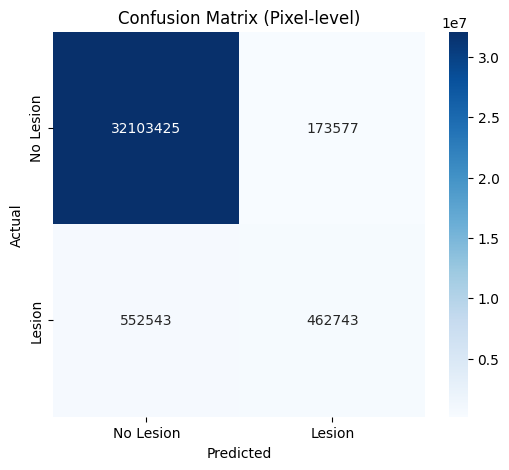

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


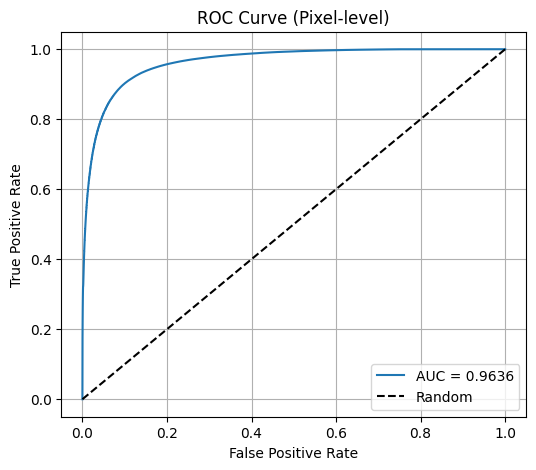

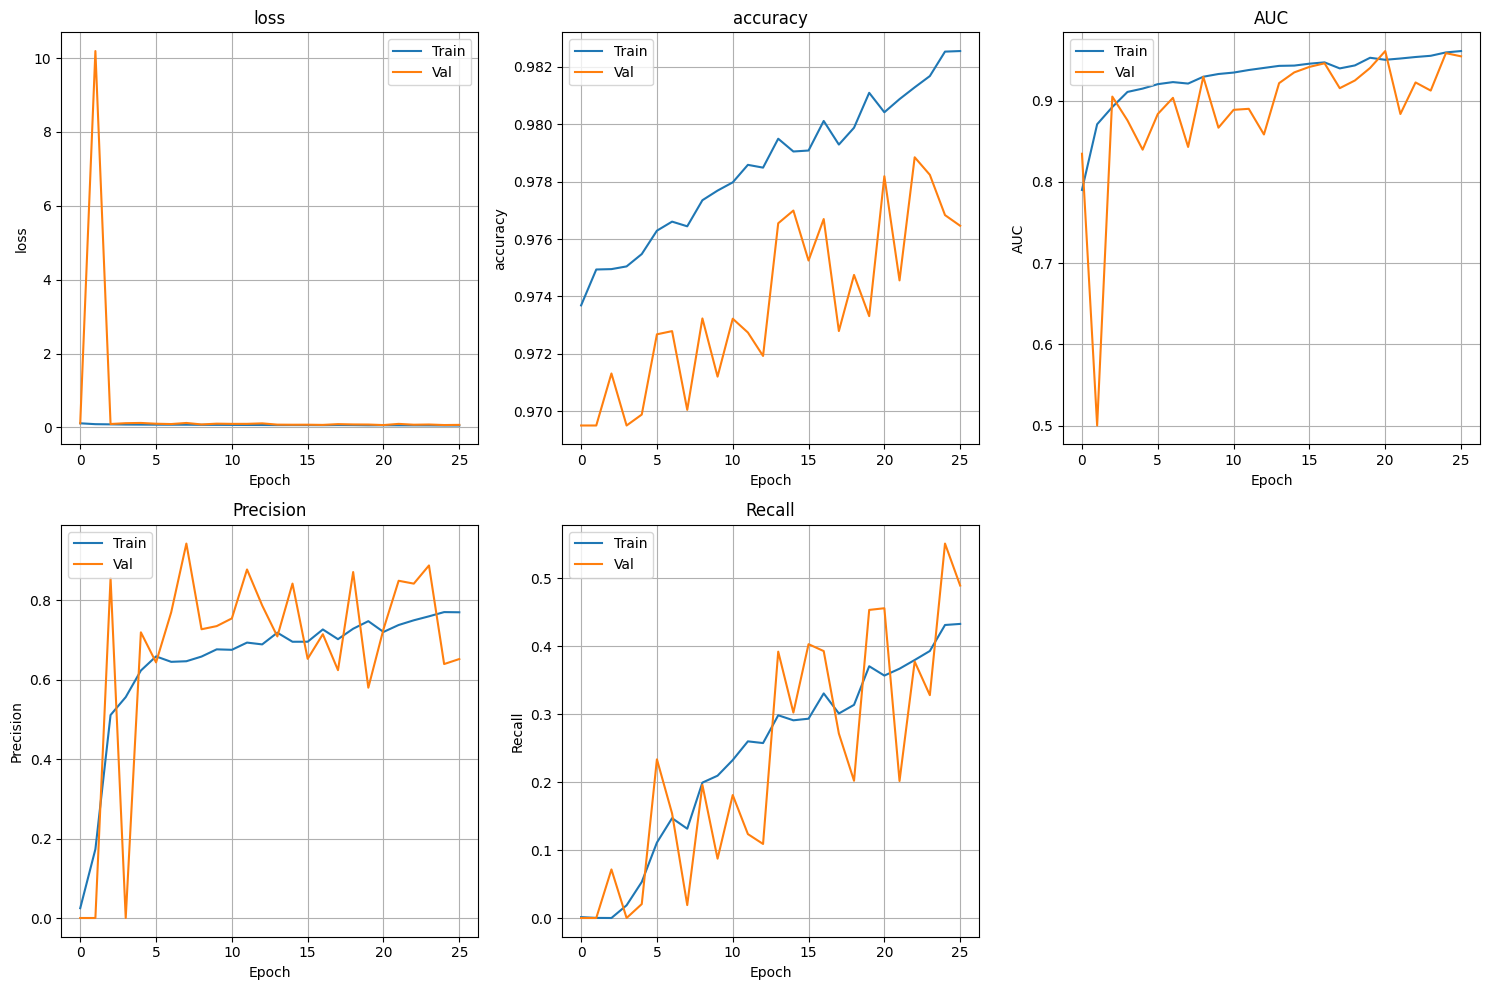

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import tensorflow as tf

# --- Get Ground Truth and Predictions ---
def get_predictions(model, dataset):
    y_true_all = []
    y_pred_all = []

    for images, masks in dataset:
        preds = model.predict(images)
        y_true_all.append(masks.numpy())
        y_pred_all.append(preds)

    y_true_all = np.concatenate(y_true_all, axis=0)
    y_pred_all = np.concatenate(y_pred_all, axis=0)
    return y_true_all, y_pred_all

y_true, y_pred = get_predictions(model, val_ds)

# Flatten to (N,) for binary evaluation
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# --- Threshold predictions for binary mask ---
THRESHOLD = 0.5
y_pred_bin = (y_pred_flat >= THRESHOLD).astype(np.uint8)

# --- Accuracy ---
accuracy = np.mean(y_true_flat == y_pred_bin)
print(f"\n✅ Pixel Accuracy: {accuracy:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_true_flat, y_pred_bin)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lesion", "Lesion"], yticklabels=["No Lesion", "Lesion"])
plt.title("Confusion Matrix (Pixel-level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC & AUC ---
auc = roc_auc_score(y_true_flat, y_pred_flat)
fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Pixel-level)")
plt.legend()
plt.grid()
plt.show()

# --- Loss and Metrics Plot ---
def plot_training_history(history):
    metrics = ['loss', 'accuracy', 'AUC', 'Precision', 'Recall']
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i + 1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Val')
        plt.title(metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training_history(history)


Dice loss

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

# --- Config ---
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'

# --- Data Loading ---
def preprocess_image_mask(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(cv2.resize(img, IMAGE_SIZE), cv2.COLOR_BGR2RGB) / 255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMAGE_SIZE)
    mask = (mask > 10).astype(np.float32)
    return img, np.expand_dims(mask, axis=-1)

VALID_EXTENSIONS = {'.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.tif', '.tiff', '.TIF', '.TIFF'}

def get_base_name(filename):
    base = Path(filename).stem
    if '_' in base:
        base = base.split('_')[0]
    return base.lower()

image_files, mask_files = [], []
mask_dict = {}

for root, _, files in os.walk(MASK_DIR):
    for fname in files:
        ext = Path(fname).suffix
        if ext in VALID_EXTENSIONS:
            base = get_base_name(fname)
            mask_dict[base] = os.path.join(root, fname)

for root, _, files in os.walk(IMAGE_DIR):
    for fname in files:
        ext = Path(fname).suffix
        if ext in VALID_EXTENSIONS:
            base = get_base_name(fname)
            if base in mask_dict:
                image_files.append(os.path.join(root, fname))
                mask_files.append(mask_dict[base])

print(f"Total image-mask pairs found: {len(image_files)}")

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# --- TF Dataset ---
def parse_fn(img_path, mask_path):
    img_path, mask_path = img_path.decode(), mask_path.decode()
    img, mask = preprocess_image_mask(img_path, mask_path)
    return img.astype(np.float32), mask.astype(np.float32)

def tf_parse(img_path, mask_path):
    img, mask = tf.numpy_function(parse_fn, [img_path, mask_path], [tf.float32, tf.float32])
    img.set_shape([*IMAGE_SIZE, 3])
    mask.set_shape([*IMAGE_SIZE, 1])
    return img, mask

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.flip_left_right(img), tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.flip_up_down(img), tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.rot90(img), tf.image.rot90(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_brightness(img, max_delta=0.2)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_contrast(img, 0.8, 1.2)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_saturation(img, 0.8, 1.2)
    return img, mask


def get_dataset(img_paths, mask_paths, augment_data=False):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(tf_parse, num_parallel_calls=AUTOTUNE)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = get_dataset(train_imgs, train_masks, augment_data=True)
val_ds = get_dataset(val_imgs, val_masks, augment_data=False)

# --- Custom Layer for Resizing ---
class ResizeToMatch(tf.keras.layers.Layer):
    def call(self, inputs):
        source, reference = inputs  # source = feature to resize, reference = target for spatial size
        target_shape = tf.shape(reference)[1:3]
        return tf.image.resize(source, target_shape, method='bilinear')


# --- Dice Loss ---
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) /
                (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))

# --- DeepLabV3+ Model with DenseNet201 ---
def DeeplabV3Plus_DenseNet(input_shape=(256, 256, 3), num_classes=1):
    base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)

    high_level_feature = base_model.get_layer('conv5_block32_concat').output
    low_level_feature = base_model.get_layer('conv2_block6_concat').output

    # ASPP
    b0 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(high_level_feature)
    b0 = tf.keras.layers.BatchNormalization()(b0)
    b0 = tf.keras.layers.ReLU()(b0)

    b1 = tf.keras.layers.DepthwiseConv2D(3, dilation_rate=6, padding="same", use_bias=False)(high_level_feature)
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.ReLU()(b1)

    b2 = tf.keras.layers.DepthwiseConv2D(3, dilation_rate=12, padding="same", use_bias=False)(high_level_feature)
    b2 = tf.keras.layers.BatchNormalization()(b2)
    b2 = tf.keras.layers.ReLU()(b2)

    b3 = tf.keras.layers.DepthwiseConv2D(3, dilation_rate=18, padding="same", use_bias=False)(high_level_feature)
    b3 = tf.keras.layers.BatchNormalization()(b3)
    b3 = tf.keras.layers.ReLU()(b3)

    b4 = tf.keras.layers.GlobalAveragePooling2D()(high_level_feature)
    b4 = tf.keras.layers.Reshape((1, 1, high_level_feature.shape[-1]))(b4)
    b4 = tf.keras.layers.Conv2D(256, 1, padding="same", use_bias=False)(b4)
    b4 = tf.keras.layers.BatchNormalization()(b4)
    b4 = tf.keras.layers.ReLU()(b4)
    b4 = tf.keras.layers.Resizing(
        height=high_level_feature.shape[1],
        width=high_level_feature.shape[2],
        interpolation='bilinear'
    )(b4)

    # Concatenate ASPP
    x = tf.keras.layers.Concatenate()([b0, b1, b2, b3, b4])
    x = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Resize x to match low-level feature
    x = ResizeToMatch()([x, low_level_feature])

    # Low-level feature projection
    low_proj = tf.keras.layers.Conv2D(48, 1, padding="same", use_bias=False)(low_level_feature)
    low_proj = tf.keras.layers.BatchNormalization()(low_proj)
    low_proj = tf.keras.layers.ReLU()(low_proj)

    x = tf.keras.layers.Concatenate()([x, low_proj])
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    x = tf.keras.layers.Resizing(input_shape[0], input_shape[1], interpolation='bilinear')(x)
    output = tf.keras.layers.Conv2D(num_classes, 1, padding="same", activation='sigmoid')(x)

    return tf.keras.Model(inputs=base_model.input, outputs=output)

# --- Compile and Train ---
model_dice = DeeplabV3Plus_DenseNet()

def dice_bce_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_loss = 1 - ((2. * intersection + smooth) /
                     (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return dice_loss + tf.reduce_mean(bce)


model_dice.compile(
    optimizer='adam',
    loss=dice_bce_loss,
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.Recall(name='Recall')
    ]
)

history = model_dice.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('deeplabv3plus_best_dice.h5', save_best_only=True, monitor='val_AUC', mode='max')
    ]
)



Total image-mask pairs found: 2539
Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.7014 - Precision: 0.1158 - Recall: 0.0892 - accuracy: 0.9583 - loss: 1.0685   

254/254 ━━━━━━━━━━━━━━━━━━━━ 715s 1s/step - AUC: 0.7016 - Precision: 0.1161 - Recall: 0.0895 - accuracy: 0.9583 - loss: 1.0682 - val_AUC: 0.4619 - val_Precision: 0.0253 - val_Recall: 0.0174 - val_accuracy: 0.9496 - val_loss: 1.2624
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - AUC: 0.8051 - Precision: 0.2886 - Recall: 0.3030 - accuracy: 0.9646 - loss: 0.8777

254/254 ━━━━━━━━━━━━━━━━━━━━ 97s 382ms/step - AUC: 0.8051 - Precision: 0.2887 - Recall: 0.3030 - accuracy: 0.9646 - loss: 0.8777 - val_AUC: 0.7331 - val_Precision: 0.1450 - val_Recall: 0.2397 - val_accuracy: 0.9337 - val_loss: 1.0691
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - AUC: 0.8164 - Precision: 0.3159 - Recall: 0.3249 - accuracy: 0.9662 - loss: 0.8453

254/254 ━━━━━━━━━━━━━━━━━━━━ 97s 382ms/step - AUC: 0.8164 - Precision: 0.3160 - Recall: 0.3249 - accuracy: 0.9662 - loss: 0.8453 - val_AUC: 0.8014 - val_Precision: 0.4370 - val_Recall: 0.1849 - val_accuracy: 0.9679 - val_loss: 0.9139
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - AUC: 0.8140 - Precision: 0.3466 - Recall: 0.3328 - accuracy: 0.9683 - loss: 0.8354

254/254 ━━━━━━━━━━━━━━━━━━━━ 98s 381ms/step - AUC: 0.8140 - Precision: 0.3466 - Recall: 0.3329 - accuracy: 0.9683 - loss: 0.8353 - val_AUC: 0.8373 - val_Precision: 0.5150 - val_Recall: 0.1673 - val_accuracy: 0.9698 - val_loss: 0.9010
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 92s 362ms/step - AUC: 0.8329 - Precision: 0.3980 - Recall: 0.3784 - accuracy: 0.9708 - loss: 0.7815 - val_AUC: 0.7428 - val_Precision: 0.2220 - val_Recall: 0.3318 - val_accuracy: 0.9442 - val_loss: 0.9853
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 358ms/step - AUC: 0.8279 - Precision: 0.4019 - Recall: 0.3770 - accuracy: 0.9710 - loss: 0.7797 - val_AUC: 0.8021 - val_Precision: 0.6245 - val_Recall: 0.2722 - val_accuracy: 0.9728 - val_loss: 0.8095
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 359ms/step - AUC: 0.8323 - Precision: 0.4160 - Recall: 0.3946 - accuracy: 0.9716 - loss: 0.7625 - val_AUC: 0.7623 - val_Precision: 0.4849 - val_Recall: 0.1921 - val_accuracy: 0.9691 - val_loss: 0.8717
Epoch 8/50
254/254 ━━━━━━━━━━━━

254/254 ━━━━━━━━━━━━━━━━━━━━ 94s 368ms/step - AUC: 0.8431 - Precision: 0.4184 - Recall: 0.4110 - accuracy: 0.9716 - loss: 0.7506 - val_AUC: 0.8595 - val_Precision: 0.4872 - val_Recall: 0.3357 - val_accuracy: 0.9690 - val_loss: 0.8008
Epoch 11/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - AUC: 0.8538 - Precision: 0.4800 - Recall: 0.4449 - accuracy: 0.9746 - loss: 0.7012

254/254 ━━━━━━━━━━━━━━━━━━━━ 94s 367ms/step - AUC: 0.8538 - Precision: 0.4800 - Recall: 0.4449 - accuracy: 0.9746 - loss: 0.7012 - val_AUC: 0.8667 - val_Precision: 0.5291 - val_Recall: 0.4682 - val_accuracy: 0.9711 - val_loss: 0.7124
Epoch 12/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 359ms/step - AUC: 0.8569 - Precision: 0.4708 - Recall: 0.4518 - accuracy: 0.9742 - loss: 0.7023 - val_AUC: 0.7094 - val_Precision: 0.7047 - val_Recall: 0.0834 - val_accuracy: 0.9710 - val_loss: 1.0365
Epoch 13/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 356ms/step - AUC: 0.8552 - Precision: 0.4931 - Recall: 0.4629 - accuracy: 0.9752 - loss: 0.6970 - val_AUC: 0.7453 - val_Precision: 0.5441 - val_Recall: 0.1630 - val_accuracy: 0.9703 - val_loss: 0.8874
Epoch 14/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 357ms/step - AUC: 0.8483 - Precision: 0.4879 - Recall: 0.4335 - accuracy: 0.9750 - loss: 0.6994 - val_AUC: 0.7959 - val_Precision: 0.4785 - val_Recall: 0.3617 - val_accuracy: 0.9685 - val_loss: 0.8039
Epoch 15/50
254/254 ━━━━━━━━

254/254 ━━━━━━━━━━━━━━━━━━━━ 93s 367ms/step - AUC: 0.8678 - Precision: 0.5323 - Recall: 0.5063 - accuracy: 0.9770 - loss: 0.6444 - val_AUC: 0.8746 - val_Precision: 0.6137 - val_Recall: 0.5244 - val_accuracy: 0.9754 - val_loss: 0.6549
Epoch 20/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 358ms/step - AUC: 0.8694 - Precision: 0.5532 - Recall: 0.4800 - accuracy: 0.9777 - loss: 0.6481 - val_AUC: 0.7975 - val_Precision: 0.5284 - val_Recall: 0.2552 - val_accuracy: 0.9703 - val_loss: 0.8835
Epoch 21/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - AUC: 0.8572 - Precision: 0.5012 - Recall: 0.4745 - accuracy: 0.9756 - loss: 0.6753

254/254 ━━━━━━━━━━━━━━━━━━━━ 93s 367ms/step - AUC: 0.8572 - Precision: 0.5013 - Recall: 0.4745 - accuracy: 0.9756 - loss: 0.6752 - val_AUC: 0.8925 - val_Precision: 0.5442 - val_Recall: 0.6008 - val_accuracy: 0.9725 - val_loss: 0.6471
Epoch 22/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 355ms/step - AUC: 0.8729 - Precision: 0.5699 - Recall: 0.5153 - accuracy: 0.9786 - loss: 0.6276 - val_AUC: 0.8837 - val_Precision: 0.3421 - val_Recall: 0.5999 - val_accuracy: 0.9526 - val_loss: 0.8299
Epoch 23/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 356ms/step - AUC: 0.8758 - Precision: 0.5396 - Recall: 0.5081 - accuracy: 0.9773 - loss: 0.6437 - val_AUC: 0.8533 - val_Precision: 0.4305 - val_Recall: 0.5207 - val_accuracy: 0.9644 - val_loss: 0.7938
Epoch 24/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 91s 355ms/step - AUC: 0.8658 - Precision: 0.5621 - Recall: 0.5050 - accuracy: 0.9782 - loss: 0.6355 - val_AUC: 0.8702 - val_Precision: 0.5838 - val_Recall: 0.5706 - val_accuracy: 0.9745 - val_loss: 0.6485
Epoch 25/50
254/254 ━━━━━━━━

In [ ]:
model_save_path = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/deeplabv3_model_lesion_count_Diceloss.h5'
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/deeplabv3_model_lesion_count_Diceloss.h5


In [ ]:
import os

def count_images(directory, extensions={'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if os.path.splitext(file)[1].lower() in extensions:
                count += 1
    return count

# Example usage
directory_path = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks/Fibrosis'
total_images = count_images(directory_path)
print(f"Total images: {total_images}")


Total images: 89


In [ ]:


import os
from pathlib import Path
from collections import defaultdict

# Paths
image_folder = Path( '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images')
mask_folder = Path('/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks')

# Valid mask extensions
valid_mask_exts = {'.tif', '.tiff', '.jpg', '.jpeg', '.png'}

# Get all image base names
image_files = [f for f in image_folder.iterdir() if f.is_file()]
image_basenames = {f.stem for f in image_files}

# Store match counts per mask subfolder
match_counts = defaultdict(int)

# Traverse mask subfolders
for root, _, files in os.walk(mask_folder):
    root_path = Path(root)
    subfolder = root_path.relative_to(mask_folder)

    for file in files:
        ext = Path(file).suffix.lower()
        if ext not in valid_mask_exts:
            continue

        file_stem = Path(file).stem
        base_name = file_stem.split('_')[0]  # Adjust if needed

        if base_name in image_basenames:
            match_counts[str(subfolder)] += 1

# Print summary
print("\n📊 Matched Mask–Image Pairs by Subfolder:")
total = 0
for subfolder, count in match_counts.items():
    print(f" - {subfolder}: {count} matched pair(s)")
    total += count

print(f"\n✅ Total matched pairs: {total}")



📊 Matched Mask–Image Pairs by Subfolder:
 - Abnormal_vein_Elsewhere_NVE: 90 matched pair(s)
 - Abnormal_vein_IRMA: 119 matched pair(s)
 - Abnormal_vein_Optic_Disk_NVD: 68 matched pair(s)
 - Cotton_Wool_Spots: 384 matched pair(s)
 - Fibrosis: 89 matched pair(s)
 - Hemorrhage_droplets: 872 matched pair(s)
 - Microaneurysms: 696 matched pair(s)
 - Vitrous_Hemorrhage: 73 matched pair(s)
 - Exudates: 865 matched pair(s)

✅ Total matched pairs: 3256


**Best Model Till Now**

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import scipy.ndimage as ndi

# Paths
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'

# Parameters
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
VALID_EXTENSIONS = {'.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.tif', '.tiff', '.TIF', '.TIFF'}



In [ ]:
def get_base_name(filename):
    base = Path(filename).stem
    if '_' in base:
        base = base.split('_')[0]
    return base.lower()

IMAGE_SIZE = (256, 256)  # Or (256, 256) if GPU is limited

def preprocess_image_mask(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMAGE_SIZE)
    mask = (mask > 10).astype(np.float32)

    return img, np.expand_dims(mask, axis=-1)

def parse_fn(img_path, mask_path):
    img_path, mask_path = img_path.decode(), mask_path.decode()
    img, mask = preprocess_image_mask(img_path, mask_path)
    return img.astype(np.float32), mask.astype(np.float32)

def tf_parse(img_path, mask_path):
    img, mask = tf.numpy_function(parse_fn, [img_path, mask_path], [tf.float32, tf.float32])
    img.set_shape([None, None, 3])
    mask.set_shape([None, None, 1])
    return img, mask

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.flip_left_right(img), tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.flip_up_down(img), tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_brightness(img, max_delta=0.2)
    return img, mask

def get_dataset(img_paths, mask_paths, augment_data=False):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(tf_parse, num_parallel_calls=AUTOTUNE)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [ ]:
from collections import defaultdict

image_files, mask_files = [], []
mask_dict = {}
matched_counts = defaultdict(int)

for root, _, files in os.walk(MASK_DIR):
    for fname in files:
        ext = Path(fname).suffix
        if ext in VALID_EXTENSIONS:
            base = get_base_name(fname)
            mask_dict[base] = os.path.join(root, fname)

for fname in os.listdir(IMAGE_DIR):
    ext = Path(fname).suffix
    if ext in VALID_EXTENSIONS:
        base = get_base_name(fname)
        if base in mask_dict:
            image_path = os.path.join(IMAGE_DIR, fname)
            mask_path = mask_dict[base]
            image_files.append(image_path)
            mask_files.append(mask_path)

            subfolder = Path(mask_path).parent.name
            matched_counts[subfolder] += 1

print("\n📊 Matched Mask–Image Pairs by Subfolder:")
for k, v in matched_counts.items():
    print(f" - {k}: {v} matched pair(s)")



📊 Matched Mask–Image Pairs by Subfolder:
 - Exudates: 1291 matched pair(s)
 - Hemorrhage_droplets: 438 matched pair(s)
 - Fibrosis: 62 matched pair(s)
 - Vitrous_Hemorrhage: 175 matched pair(s)
 - Microaneurysms: 483 matched pair(s)
 - Abnormal_vein_Optic_Disk_NVD: 25 matched pair(s)
 - Abnormal_vein_Elsewhere_NVE: 19 matched pair(s)
 - Cotton_Wool_Spots: 20 matched pair(s)
 - Abnormal_vein_IRMA: 26 matched pair(s)


In [ ]:
class ResizeFeatureMap(tf.keras.layers.Layer):
    def call(self, inputs):
        feature, target = inputs
        target_shape = tf.shape(target)[1:3]
        return tf.image.resize(feature, target_shape, method='bilinear')



def dice_loss(y_true, y_pred, smooth=1.):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom Layer to Resize Feature Maps to Match a Target
class ResizeToMatch(tf.keras.layers.Layer):
    def call(self, inputs):
        source, target = inputs
        target_shape = tf.shape(target)[1:3]
        return tf.image.resize(source, target_shape, method='bilinear')

# Custom Layer for Feature Pyramid Pooling (Global)
class ResizeFeatureMap(tf.keras.layers.Layer):
    def call(self, inputs):
        source, target = inputs
        target_shape = tf.shape(target)[1:3]
        return tf.image.resize(source, target_shape, method='bilinear')

def DeeplabV3Plus_DenseNet(input_shape=(256, 256, 3), num_classes=1):
    base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)

    # Extract feature maps
    high = base_model.get_layer('conv5_block32_concat').output  # deeper
    low = base_model.get_layer('conv2_block6_concat').output    # shallower

    def conv_bn_relu(x, filters=256):
        x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        return layers.ReLU()(x)

    # Atrous Spatial Pyramid Pooling (ASPP)
    b0 = conv_bn_relu(high)
    b1 = layers.DepthwiseConv2D(3, dilation_rate=6, padding="same", use_bias=False)(high)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.ReLU()(b1)

    b2 = layers.DepthwiseConv2D(3, dilation_rate=12, padding="same", use_bias=False)(high)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.ReLU()(b2)

    b3 = layers.DepthwiseConv2D(3, dilation_rate=18, padding="same", use_bias=False)(high)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.ReLU()(b3)

    b4 = layers.GlobalAveragePooling2D()(high)
    b4 = layers.Reshape((1, 1, high.shape[-1]))(b4)
    b4 = conv_bn_relu(b4)
    b4 = ResizeFeatureMap()([b4, high])

    x = layers.Concatenate()([b0, b1, b2, b3, b4])
    x = conv_bn_relu(x)
    x = ResizeToMatch()([x, low])

    low_proj = layers.Conv2D(48, 1, padding="same", use_bias=False)(low)
    low_proj = layers.BatchNormalization()(low_proj)
    low_proj = layers.ReLU()(low_proj)

    x = layers.Concatenate()([x, low_proj])
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    # Final segmentation output
    x = layers.Conv2D(num_classes, 1, padding="same", activation='sigmoid')(x)

    # Resize output to match original input shape (256x256)
    x = layers.Resizing(input_shape[0], input_shape[1], interpolation='bilinear')(x)

    return models.Model(inputs=base_model.input, outputs=x)



In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.3 MB/s eta 0:00:00


In [ ]:
pip show keras-tuner

Name: keras-tuner
Version: 1.4.7
Summary: A Hyperparameter Tuning Library for Keras
Home-page: https://github.com/keras-team/keras-tuner
Author: The KerasTuner authors
Author-email: 
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: keras, kt-legacy, packaging, requests
Required-by: 


Input batch shape: (8, 256, 256, 3)
Mask batch shape: (8, 256, 256, 1)


NameError: name 'model' is not defined

Trial 2 Complete [00h 02m 25s]

Best val_AUC So Far: None
Total elapsed time: 00h 04m 50s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
0.4               |0.5               |dropout_rate
128               |128               |filters
0.001             |0.001             |learning_rate

Epoch 1/20


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-pa

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/execute.py", line 59, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [1,524288] vs. [1,4718592]
	 [[{{node LogicalAnd}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_460794[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_465422]


In [ ]:
best_model = tuner.get_best_models(1)[0]
best_model.save("deeplabv3plus_best_tuned.h5")

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hp.values)

In [ ]:


model = DeeplabV3Plus_DenseNet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.Recall(name='Recall')
    ]
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('deeplabv3plus_best_v1.h5', save_best_only=True, monitor='val_AUC', mode='max')
    ]
)


Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.7819 - Precision: 0.0855 - Recall: 0.0200 - binary_accuracy: 0.9635 - loss: 0.1184   

254/254 ━━━━━━━━━━━━━━━━━━━━ 762s 1s/step - AUC: 0.7822 - Precision: 0.0864 - Recall: 0.0201 - binary_accuracy: 0.9635 - loss: 0.1183 - val_AUC: 0.8912 - val_Precision: 1.0000 - val_Recall: 0.0017 - val_binary_accuracy: 0.9696 - val_loss: 0.1176
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - AUC: 0.9313 - Precision: 0.6711 - Recall: 0.1898 - binary_accuracy: 0.9779 - loss: 0.0678

254/254 ━━━━━━━━━━━━━━━━━━━━ 73s 287ms/step - AUC: 0.9313 - Precision: 0.6711 - Recall: 0.1899 - binary_accuracy: 0.9779 - loss: 0.0678 - val_AUC: 0.9524 - val_Precision: 0.8461 - val_Recall: 0.2845 - val_binary_accuracy: 0.9766 - val_loss: 0.0693
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - AUC: 0.9541 - Precision: 0.7582 - Recall: 0.3584 - binary_accuracy: 0.9815 - loss: 0.0555

254/254 ━━━━━━━━━━━━━━━━━━━━ 75s 296ms/step - AUC: 0.9541 - Precision: 0.7582 - Recall: 0.3584 - binary_accuracy: 0.9815 - loss: 0.0555 - val_AUC: 0.9529 - val_Precision: 0.8308 - val_Recall: 0.3779 - val_binary_accuracy: 0.9787 - val_loss: 0.0644
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 73s 284ms/step - AUC: 0.9606 - Precision: 0.7515 - Recall: 0.3923 - binary_accuracy: 0.9820 - loss: 0.0520 - val_AUC: 0.9245 - val_Precision: 0.8515 - val_Recall: 0.3534 - val_binary_accuracy: 0.9784 - val_loss: 0.0745
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - AUC: 0.9701 - Precision: 0.7747 - Recall: 0.4564 - binary_accuracy: 0.9835 - loss: 0.0462

254/254 ━━━━━━━━━━━━━━━━━━━━ 76s 297ms/step - AUC: 0.9702 - Precision: 0.7747 - Recall: 0.4565 - binary_accuracy: 0.9835 - loss: 0.0462 - val_AUC: 0.9642 - val_Precision: 0.7824 - val_Recall: 0.6186 - val_binary_accuracy: 0.9831 - val_loss: 0.0512
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 73s 287ms/step - AUC: 0.9762 - Precision: 0.8035 - Recall: 0.5365 - binary_accuracy: 0.9855 - loss: 0.0406 - val_AUC: 0.9618 - val_Precision: 0.8593 - val_Recall: 0.5378 - val_binary_accuracy: 0.9832 - val_loss: 0.0509
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 73s 288ms/step - AUC: 0.9786 - Precision: 0.8132 - Recall: 0.5384 - binary_accuracy: 0.9857 - loss: 0.0393 - val_AUC: 0.9625 - val_Precision: 0.7464 - val_Recall: 0.6330 - val_binary_accuracy: 0.9822 - val_loss: 0.0546
Epoch 8/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - AUC: 0.9791 - Precision: 0.8224 - Recall: 0.5642 - binary_accuracy: 0.9864 - loss: 0.0378

254/254 ━━━━━━━━━━━━━━━━━━━━ 76s 298ms/step - AUC: 0.9791 - Precision: 0.8224 - Recall: 0.5643 - binary_accuracy: 0.9864 - loss: 0.0378 - val_AUC: 0.9711 - val_Precision: 0.7810 - val_Recall: 0.6458 - val_binary_accuracy: 0.9837 - val_loss: 0.0487
Epoch 9/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - AUC: 0.9823 - Precision: 0.8314 - Recall: 0.5896 - binary_accuracy: 0.9871 - loss: 0.0354

254/254 ━━━━━━━━━━━━━━━━━━━━ 77s 299ms/step - AUC: 0.9823 - Precision: 0.8314 - Recall: 0.5896 - binary_accuracy: 0.9871 - loss: 0.0354 - val_AUC: 0.9782 - val_Precision: 0.8405 - val_Recall: 0.6273 - val_binary_accuracy: 0.9850 - val_loss: 0.0431
Epoch 10/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 74s 291ms/step - AUC: 0.9820 - Precision: 0.8351 - Recall: 0.5789 - binary_accuracy: 0.9869 - loss: 0.0356 - val_AUC: 0.9594 - val_Precision: 0.8713 - val_Recall: 0.4786 - val_binary_accuracy: 0.9819 - val_loss: 0.0555
Epoch 11/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 73s 287ms/step - AUC: 0.9815 - Precision: 0.8390 - Recall: 0.5705 - binary_accuracy: 0.9868 - loss: 0.0361 - val_AUC: 0.9724 - val_Precision: 0.8339 - val_Recall: 0.6071 - val_binary_accuracy: 0.9843 - val_loss: 0.0465
Epoch 12/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - AUC: 0.9837 - Precision: 0.8470 - Recall: 0.6045 - binary_accuracy: 0.9877 - loss: 0.0336

254/254 ━━━━━━━━━━━━━━━━━━━━ 76s 298ms/step - AUC: 0.9837 - Precision: 0.8470 - Recall: 0.6046 - binary_accuracy: 0.9877 - loss: 0.0336 - val_AUC: 0.9796 - val_Precision: 0.7851 - val_Recall: 0.6720 - val_binary_accuracy: 0.9844 - val_loss: 0.0448
Epoch 13/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 74s 290ms/step - AUC: 0.9855 - Precision: 0.8519 - Recall: 0.6176 - binary_accuracy: 0.9880 - loss: 0.0321 - val_AUC: 0.9711 - val_Precision: 0.8581 - val_Recall: 0.5752 - val_binary_accuracy: 0.9841 - val_loss: 0.0468
Epoch 14/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 73s 288ms/step - AUC: 0.9850 - Precision: 0.8496 - Recall: 0.6110 - binary_accuracy: 0.9879 - loss: 0.0324 - val_AUC: 0.9584 - val_Precision: 0.7639 - val_Recall: 0.4825 - val_binary_accuracy: 0.9797 - val_loss: 0.0640


In [ ]:
print(history.history.keys())

dict_keys(['AUC', 'Precision', 'Recall', 'binary_accuracy', 'loss', 'val_AUC', 'val_Precision', 'val_Recall', 'val_binary_accuracy', 'val_loss'])


In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    for metric in ['val_loss', 'val_AUC', 'val_Precision', 'val_Recall']:
        plt.plot(history.history[metric], label=f"Train {metric}")
        val_metric = f"val_{metric}"
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f"Val {metric}")
        plt.title(metric)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()


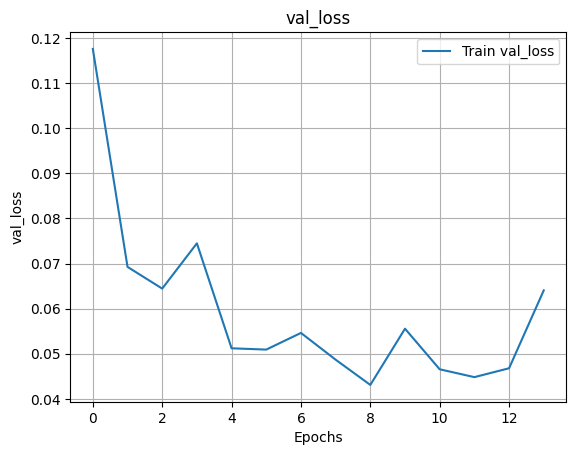

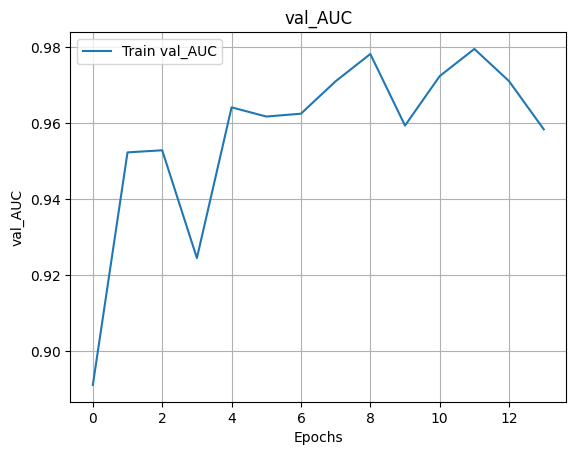

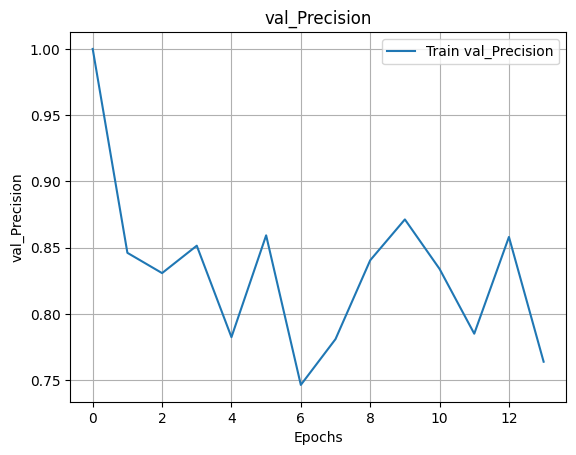

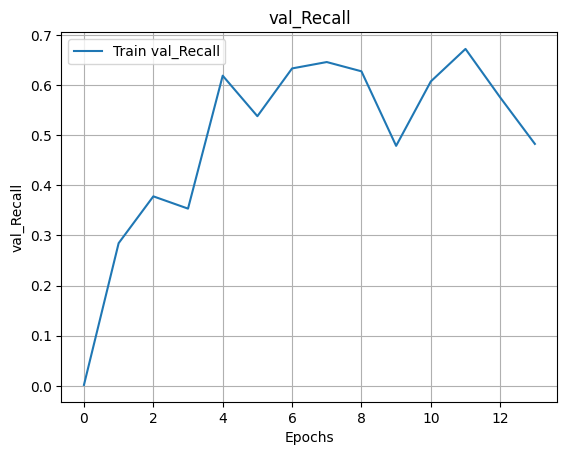

In [ ]:
plot_metrics(history)

In [ ]:
def count_connected_components(pred_mask, threshold=0.5):
    binary = (pred_mask > threshold).astype(np.uint8)
    labeled, num_features = ndi.label(binary)
    return num_features

def predict_and_count(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
    pred = model.predict(np.expand_dims(img, axis=0))[0, :, :, 0]
    count = count_connected_components(pred)
    return count

# Example usage
img_path = '/path/to/sample_image.jpg'
lesion_name = 'Microaneurysms'
count = predict_and_count(img_path)
print(f"{lesion_name}: {count}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class ResizeToMatch(tf.keras.layers.Layer):
    def call(self, inputs):
        source, target = inputs
        target_shape = tf.shape(target)[1:3]
        return tf.image.resize(source, target_shape, method='bilinear')

In [ ]:
import tensorflow as tf

class BinaryFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        focal_weight = alpha_factor * tf.pow((1 - p_t), self.gamma)
        loss = focal_weight * tf.keras.backend.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(loss)


In [ ]:
from tensorflow.keras.models import load_model

# Replace with the actual path to your model
model_path = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/model/lession_modelv2.h5'

# If custom objects (e.g. custom loss/layers) are used, pass them as argument
model = load_model(model_path, custom_objects={'ResizeToMatch': ResizeToMatch, 'BinaryFocalLoss': BinaryFocalLoss})  # Add custom_objects if needed

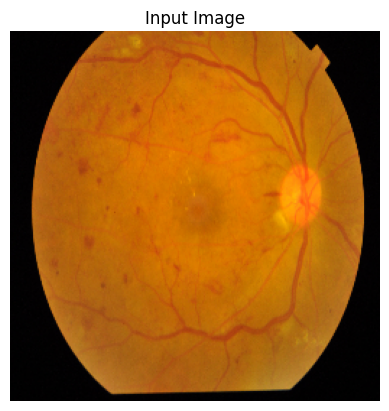

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Lesion-wise Counts:
Abnormal_vein_Elsewhere_NVE: 0
Abnormal_vein_IRMA: 0
Abnormal_vein_Optic_Disk_NVD: 0
Cotton_Wool_Spots: 0
Exudates: 0
Fibrosis: 0
Hemorrhage_droplets: 0
Microaneurysms: 0
Vitrous_Hemorrhage: 0


In [ ]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Set image path and target size
img_path = '/content/IM002721.JPG'  # << update this path
img_size = (256, 256)  # change based on your model's input

# --- Step 2: Load and preprocess image
img = load_img(img_path, target_size=img_size)
img_array = img_to_array(img)
img_array = img_array / 255.0  # normalize
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# --- Step 3: Show the image
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

# 8. Print prediction result
# If binary classification: pred is a scalar
# If multi-label: pred is a list of probabilities for each class

# Example class names
# Step 4: Run prediction
# Step 4: Run prediction
pred = model.predict(img_array)

# Flatten if necessary
pred = np.squeeze(pred)  # removes dimensions like (1, 9) → (9,)

# Step 5: Print results
class_names = ['Abnormal_vein_Elsewhere_NVE', 'Abnormal_vein_IRMA', 'Abnormal_vein_Optic_Disk_NVD',
    'Cotton_Wool_Spots', 'Exudates', 'Fibrosis',
    'Hemorrhage_droplets', 'Microaneurysms', 'Vitrous_Hemorrhage']

pred = model.predict(img_array)
pred = np.squeeze(pred)  # shape (9,)

print("Lesion-wise Counts:")
for cls, count in zip(class_names, pred):
    if isinstance(count, np.ndarray):
        count_val = count.flatten()[0]
    else:
        count_val = count
    count_val = int(round(count_val))  # convert float to int count
    print(f"{cls}: {count_val}")

In [ ]:
# Load image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img = cv2.resize(img, IMAGE_SIZE)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img / 255.0

# Load masks and count connected lesions
def load_mask_and_count(image_id):
    base_id = os.path.splitext(image_id)[0]
    counts = []

    for cls in CLASS_NAMES:
        found = False
        possible_filenames = [
            f"{base_id}_{cls}.png",
            f"{base_id}.png",
            f"{base_id}_{cls}.jpg",
            f"{base_id}.jpg"
        ]
        for fname in possible_filenames:
            mask_path = os.path.join(MASK_DIR, cls, fname)
            if os.path.exists(mask_path):
                m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if m is not None:
                    m = cv2.resize(m, IMAGE_SIZE)
                    m = (m > 10).astype(np.uint8)
                    count = label(m).max()
                    counts.append(count)
                    found = True
                    break
        if not found:
            counts.append(0)
    return counts

# Load dataset
images = []
counts = []

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


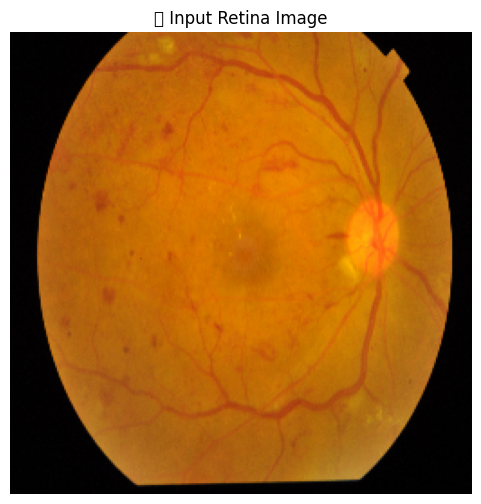


🔍 Predicted Lesion Pixel Counts (per class):
Abnormal_vein_Elsewhere_NVE: 0
Abnormal_vein_IRMA       : 0
Abnormal_vein_Optic_Disk_NVD: 0
Cotton_Wool_Spots        : 0
Exudates                 : 0
Fibrosis                 : 0
Hemorrhage_droplets      : 12
Microaneurysms           : 0
Vitrous_Hemorrhage       : 0


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Configuration ---
IMAGE_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/images'
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
CLASS_NAMES = sorted(os.listdir(MASK_DIR))  # Lesion class names
IMAGE_SIZE = (256, 256)
NUM_CLASSES = len(CLASS_NAMES)

# --- Prediction Function ---
def predict_counts_from_image(image_path):
    # Step 1: Load and preprocess image
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_input = np.expand_dims(img_array, axis=0)  # Shape: (1, 256, 256, 3)

    # Step 2: Predict segmentation masks (model should output shape: (1, 256, 256, NUM_CLASSES))
    preds = model.predict(img_input)[0]  # Shape: (256, 256, NUM_CLASSES)

    # Step 3: Display input image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("🖼 Input Retina Image")
    plt.show()

    # Step 4: Sum pixels for each lesion class
    print("\n🔍 Predicted Lesion Pixel Counts (per class):")
    for i, cls in enumerate(CLASS_NAMES):
        mask = preds[:, :, i]
        count = np.sum(mask > 0.5)  # Threshold mask to binary and count
        print(f"{cls:25}: {int(count)}")

# --- Example: Predict on a sample image ---
predict_counts_from_image('/content/IM002721.JPG')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
⚠️ No pixels detected for class: Abnormal_vein_Elsewhere_NVE
⚠️ No pixels detected for class: Abnormal_vein_IRMA
⚠️ No pixels detected for class: Abnormal_vein_Optic_Disk_NVD
⚠️ No pixels detected for class: Cotton_Wool_Spots
⚠️ No pixels detected for class: Exudates
⚠️ No pixels detected for class: Fibrosis
⚠️ No pixels detected for class: Microaneurysms
⚠️ No pixels detected for class: Vitrous_Hemorrhage
✅ Saved image with 25 bounding boxes to: /content/bbox_output.jpg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


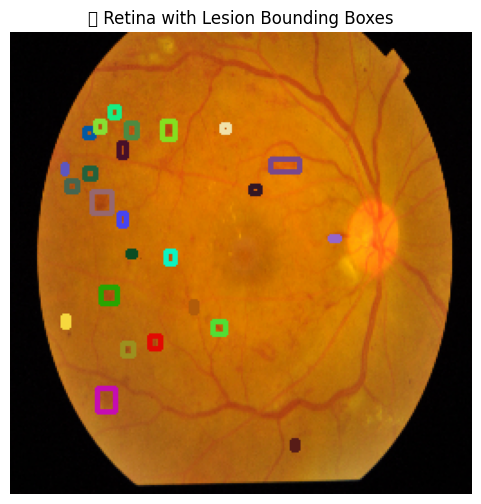

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Configuration ---
IMAGE_SIZE = (256, 256)
MASK_DIR = '/content/drive/MyDrive/DRdataset/DR_annotation_Batch_7/extracted_masks'
CLASS_NAMES = sorted(os.listdir(MASK_DIR))
NUM_CLASSES = len(CLASS_NAMES)
SAVE_PATH = '/content/bbox_output.jpg'

# --- Predict and Draw Bounding Boxes with Different Colors per Lesion ---
def predict_and_draw_bboxes(image_path, threshold=0.3, area_thresh=10):
    # Load and preprocess image
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    # Predict masks
    preds = model.predict(img_input)[0]  # shape: (256, 256, NUM_CLASSES)
    original_img = (img_array * 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)

    boxes_found = 0

    # Loop through each class
    for i, cls in enumerate(CLASS_NAMES):
        mask = preds[:, :, i]
        binary_mask = (mask > threshold).astype(np.uint8)

        if np.sum(binary_mask) == 0:
            print(f"⚠️ No pixels detected for class: {cls}")
            continue

        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt_idx, cnt in enumerate(contours):
            x, y, w, h = cv2.boundingRect(cnt)
            if w * h < area_thresh:
                continue  # skip small noise

            # Different random color per lesion instance
            color = tuple(np.random.randint(0, 255, 3).tolist())

            cv2.rectangle(img_bgr, (x, y), (x + w, y + h), color, 2)

            boxes_found += 1

    # Save image with bounding boxes
    cv2.imwrite(SAVE_PATH, img_bgr)
    print(f"✅ Saved image with {boxes_found} bounding boxes to: {SAVE_PATH}")

    # Show the image
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("🔍 Retina with Lesion Bounding Boxes")
    plt.show()

# --- Run on example image ---
predict_and_draw_bboxes('/content/IM002721.JPG')


